# 📊 Cash Flow Visualization Dashboard

Comprehensive visualizations for each country/entity showing:
- Cash flow trends (inflow vs outflow)
- Net cash position
- Category breakdown
- Anomaly detection
- Pattern analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for beautiful visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# AZ Color scheme
AZ_COLORS = {
    'primary': '#830051',
    'secondary': '#D4145A',
    'accent1': '#FF6B35',
    'accent2': '#3B7D7D',
    'positive': '#28a745',
    'negative': '#dc3545',
    'neutral': '#6c757d'
}

In [2]:
# Load all entity data
entities = ['ID10', 'KR10', 'MY10', 'PH10', 'SS10', 'TH10', 'TW10', 'VN20']
entity_data = {}

for entity in entities:
    df = pd.read_csv(f'../processed_data/weekly_{entity}.csv')
    df['Week_Start'] = pd.to_datetime(df['Week_Start'])
    entity_data[entity] = df
    print(f"Loaded {entity}: {len(df)} weeks")

# Load combined data
df_all = pd.read_csv('../processed_data/weekly_entity_features.csv')
df_all['Week_Start'] = pd.to_datetime(df_all['Week_Start'])
print(f"\nTotal combined: {len(df_all)} records")

Loaded ID10: 44 weeks
Loaded KR10: 44 weeks
Loaded MY10: 44 weeks
Loaded PH10: 44 weeks
Loaded SS10: 44 weeks
Loaded TH10: 44 weeks
Loaded TW10: 44 weeks
Loaded VN20: 44 weeks

Total combined: 352 records


---
## 1. Overview: All Entities Comparison

In [3]:
# Summary statistics for all entities
summary = df_all.groupby('Entity').agg({
    'Total_Net': ['sum', 'mean', 'std'],
    'Total_Inflow': 'sum',
    'Total_Outflow': 'sum',
    'Transaction_Count': 'sum'
}).round(2)
summary.columns = ['Total Net', 'Avg Weekly Net', 'Std Dev', 'Total Inflow', 'Total Outflow', 'Total Txns']
display(summary)

,Total Net,Avg Weekly Net,Std Dev,Total Inflow,Total Outflow,Total Txns
Entity,,,,,,
ID10,220366.43,5008.33,195785.83,10785260.74,-10564894.31,15054
KR10,-1543028.65,-35068.83,1263672.91,45709866.98,-47252895.62,11277
MY10,-1579799.21,-35904.53,332711.20,8121195.00,-9700994.21,6111
PH10,-617601.02,-14036.39,144141.58,6252693.11,-6870294.12,9375
SS10,254603.77,5786.45,98772.29,1613165.09,-1358561.31,3741
TH10,-1394474.38,-31692.60,375999.67,8026941.75,-9421416.14,7058
TW10,1137274.69,25847.15,1458178.70,29695688.04,-28558413.35,15960
VN20,-394780.74,-8972.29,428506.34,17060861.42,-17455642.16,15952


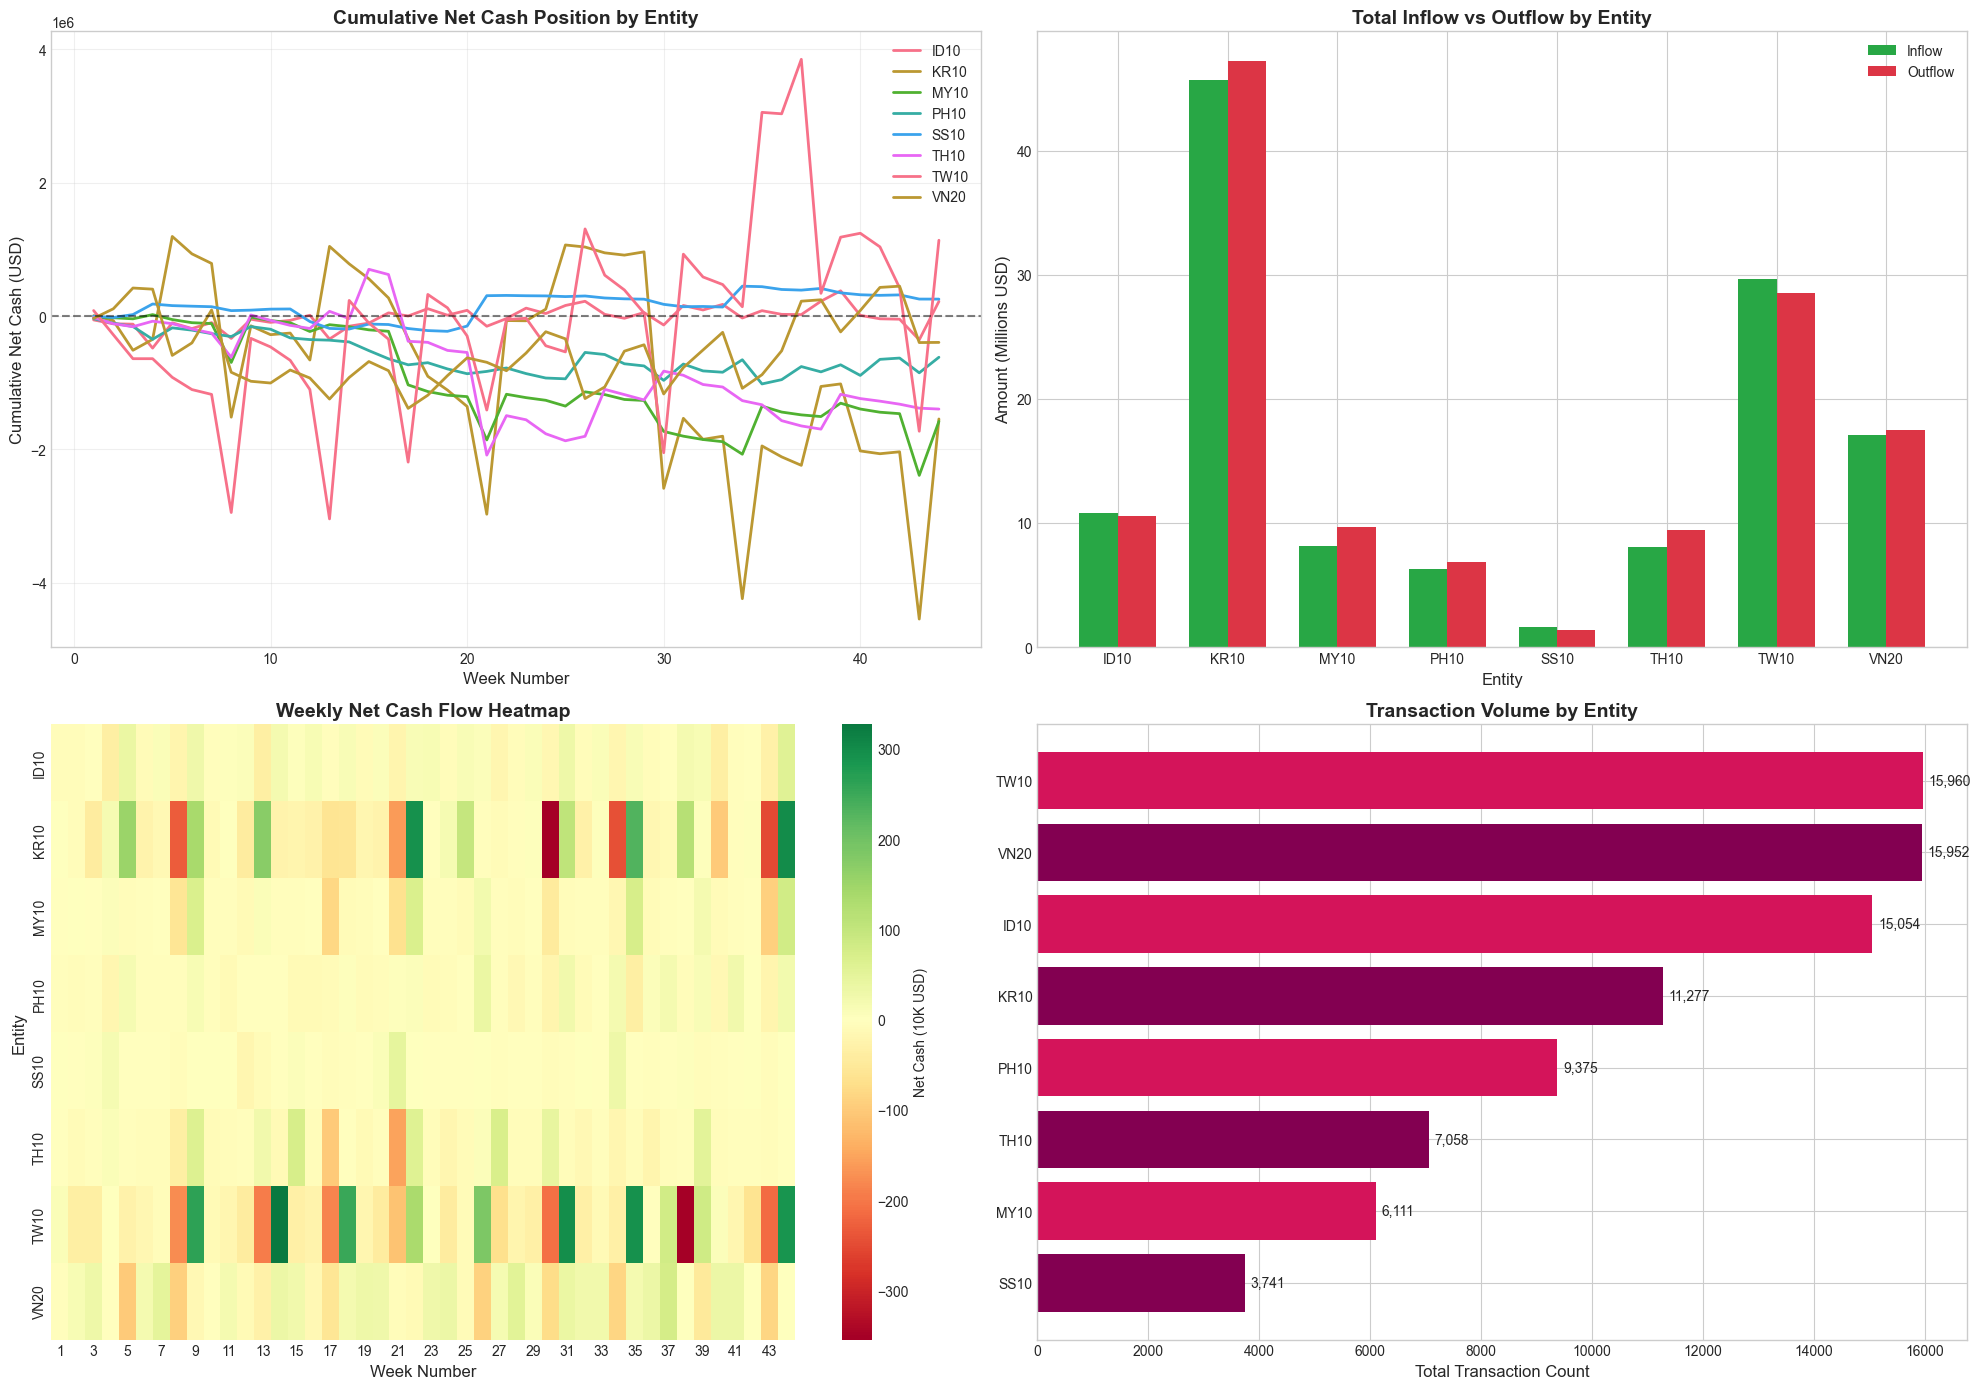

In [4]:
# Overall comparison chart
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# 1. Cumulative Net Cash by Entity
ax1 = axes[0, 0]
for entity in entities:
    df = entity_data[entity]
    ax1.plot(df['Week_Num'], df['Cumulative_Net'], label=entity, linewidth=2)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Week Number', fontsize=12)
ax1.set_ylabel('Cumulative Net Cash (USD)', fontsize=12)
ax1.set_title('Cumulative Net Cash Position by Entity', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# 2. Total Inflow vs Outflow by Entity
ax2 = axes[0, 1]
entity_totals = df_all.groupby('Entity')[['Total_Inflow', 'Outflow_Abs']].sum() / 1e6
x = np.arange(len(entities))
width = 0.35
bars1 = ax2.bar(x - width/2, entity_totals['Total_Inflow'], width, label='Inflow', color=AZ_COLORS['positive'])
bars2 = ax2.bar(x + width/2, entity_totals['Outflow_Abs'], width, label='Outflow', color=AZ_COLORS['negative'])
ax2.set_xlabel('Entity', fontsize=12)
ax2.set_ylabel('Amount (Millions USD)', fontsize=12)
ax2.set_title('Total Inflow vs Outflow by Entity', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(entity_totals.index)
ax2.legend()

# 3. Weekly Net Cash Heatmap
ax3 = axes[1, 0]
pivot_net = df_all.pivot(index='Entity', columns='Week_Num', values='Total_Net')
sns.heatmap(pivot_net / 1e4, cmap='RdYlGn', center=0, ax=ax3, cbar_kws={'label': 'Net Cash (10K USD)'})
ax3.set_title('Weekly Net Cash Flow Heatmap', fontsize=14, fontweight='bold')
ax3.set_xlabel('Week Number', fontsize=12)
ax3.set_ylabel('Entity', fontsize=12)

# 4. Transaction Volume by Entity
ax4 = axes[1, 1]
txn_by_entity = df_all.groupby('Entity')['Transaction_Count'].sum().sort_values(ascending=True)
colors = [AZ_COLORS['primary'] if i % 2 == 0 else AZ_COLORS['secondary'] for i in range(len(txn_by_entity))]
ax4.barh(txn_by_entity.index, txn_by_entity.values, color=colors)
ax4.set_xlabel('Total Transaction Count', fontsize=12)
ax4.set_title('Transaction Volume by Entity', fontsize=14, fontweight='bold')
for i, v in enumerate(txn_by_entity.values):
    ax4.text(v + 100, i, f'{v:,}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/overview_all_entities.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 2. Individual Entity Dashboards

Detailed analysis for each country/entity

In [5]:
def create_entity_dashboard(entity_name, df):
    """Create comprehensive dashboard for a single entity"""
    fig = plt.figure(figsize=(24, 20))
    
    # Create grid
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    
    # === ROW 1: Cash Flow Overview ===
    # 1.1 Inflow vs Outflow over time
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.fill_between(df['Week_Num'], df['Total_Inflow']/1e3, alpha=0.5, label='Inflow', color=AZ_COLORS['positive'])
    ax1.fill_between(df['Week_Num'], -df['Outflow_Abs']/1e3, alpha=0.5, label='Outflow', color=AZ_COLORS['negative'])
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax1.set_xlabel('Week Number')
    ax1.set_ylabel('Amount (Thousands USD)')
    ax1.set_title(f'{entity_name}: Weekly Inflow vs Outflow', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 1.2 Net Cash Pie (Positive vs Negative weeks)
    ax2 = fig.add_subplot(gs[0, 2])
    pos_weeks = (df['Total_Net'] > 0).sum()
    neg_weeks = (df['Total_Net'] <= 0).sum()
    ax2.pie([pos_weeks, neg_weeks], labels=['Positive', 'Negative'], 
            colors=[AZ_COLORS['positive'], AZ_COLORS['negative']], autopct='%1.1f%%',
            explode=(0.05, 0), shadow=True)
    ax2.set_title(f'Week Distribution\n(Positive vs Negative Net)', fontsize=12, fontweight='bold')
    
    # === ROW 2: Net Cash & Trends ===
    # 2.1 Net Cash with Rolling Average
    ax3 = fig.add_subplot(gs[1, :2])
    ax3.bar(df['Week_Num'], df['Total_Net']/1e3, 
            color=[AZ_COLORS['positive'] if x > 0 else AZ_COLORS['negative'] for x in df['Total_Net']],
            alpha=0.7, label='Weekly Net')
    if 'Net_Rolling4_Mean' in df.columns:
        ax3.plot(df['Week_Num'], df['Net_Rolling4_Mean']/1e3, color=AZ_COLORS['primary'], 
                 linewidth=3, label='4-Week Rolling Avg')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax3.set_xlabel('Week Number')
    ax3.set_ylabel('Net Cash (Thousands USD)')
    ax3.set_title(f'{entity_name}: Weekly Net Cash Flow with Trend', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 2.2 Cumulative Cash Position
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.fill_between(df['Week_Num'], df['Cumulative_Net']/1e3, alpha=0.5, color=AZ_COLORS['accent2'])
    ax4.plot(df['Week_Num'], df['Cumulative_Net']/1e3, color=AZ_COLORS['accent2'], linewidth=2)
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Week Number')
    ax4.set_ylabel('Cumulative (Thousands USD)')
    ax4.set_title('Cumulative Cash Position', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # === ROW 3: Category Analysis ===
    # 3.1 Category Breakdown (Top categories)
    ax5 = fig.add_subplot(gs[2, :2])
    cat_cols = [c for c in df.columns if c.startswith('Cat_') and c.endswith('_Net')]
    cat_totals = df[cat_cols].sum().sort_values()
    cat_totals.index = [c.replace('Cat_', '').replace('_Net', '') for c in cat_totals.index]
    colors = [AZ_COLORS['positive'] if x > 0 else AZ_COLORS['negative'] for x in cat_totals]
    ax5.barh(cat_totals.index, cat_totals.values/1e3, color=colors)
    ax5.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax5.set_xlabel('Total Net Cash (Thousands USD)')
    ax5.set_title(f'{entity_name}: Cash Flow by Category', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='x')
    
    # 3.2 Top Categories by Transaction Count
    ax6 = fig.add_subplot(gs[2, 2])
    cat_count_cols = [c for c in df.columns if c.startswith('Cat_') and c.endswith('_Count')]
    cat_counts = df[cat_count_cols].sum().sort_values(ascending=False).head(8)
    cat_counts.index = [c.replace('Cat_', '').replace('_Count', '') for c in cat_counts.index]
    ax6.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90)
    ax6.set_title('Transaction Distribution\nby Category', fontsize=12, fontweight='bold')
    
    # === ROW 4: Anomaly Detection ===
    # 4.1 Identify anomalies using IQR
    ax7 = fig.add_subplot(gs[3, :2])
    Q1 = df['Total_Net'].quantile(0.25)
    Q3 = df['Total_Net'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df['is_anomaly'] = (df['Total_Net'] < lower_bound) | (df['Total_Net'] > upper_bound)
    
    ax7.scatter(df[~df['is_anomaly']]['Week_Num'], df[~df['is_anomaly']]['Total_Net']/1e3,
                color=AZ_COLORS['accent2'], s=50, alpha=0.7, label='Normal')
    ax7.scatter(df[df['is_anomaly']]['Week_Num'], df[df['is_anomaly']]['Total_Net']/1e3,
                color=AZ_COLORS['secondary'], s=150, marker='*', label='Anomaly')
    ax7.axhline(y=upper_bound/1e3, color='orange', linestyle='--', alpha=0.7, label='Upper Bound')
    ax7.axhline(y=lower_bound/1e3, color='orange', linestyle='--', alpha=0.7, label='Lower Bound')
    ax7.set_xlabel('Week Number')
    ax7.set_ylabel('Net Cash (Thousands USD)')
    ax7.set_title(f'{entity_name}: Anomaly Detection (IQR Method)', fontsize=14, fontweight='bold')
    ax7.legend(loc='best')
    ax7.grid(True, alpha=0.3)
    
    # 4.2 Monthly Pattern Analysis
    ax8 = fig.add_subplot(gs[3, 2])
    if 'Month' in df.columns:
        monthly = df.groupby('Month')['Total_Net'].mean()
        colors = [AZ_COLORS['positive'] if x > 0 else AZ_COLORS['negative'] for x in monthly]
        ax8.bar(monthly.index, monthly.values/1e3, color=colors)
        ax8.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax8.set_xlabel('Month')
        ax8.set_ylabel('Avg Net Cash (Thousands USD)')
        ax8.set_title('Average Net Cash by Month', fontsize=12, fontweight='bold')
        ax8.grid(True, alpha=0.3)
    
    plt.suptitle(f'📊 {entity_name} Cash Flow Dashboard', fontsize=20, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'../outputs/dashboard_{entity_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print anomalies
    anomalies = df[df['is_anomaly']][['Week_Num', 'Week_Start', 'Total_Net', 'Total_Inflow', 'Outflow_Abs']]
    if len(anomalies) > 0:
        print(f"\n⚠️ Anomalies detected for {entity_name}:")
        display(anomalies)
    else:
        print(f"\n✅ No anomalies detected for {entity_name}")
    
    return df


🏢 ENTITY: ID10


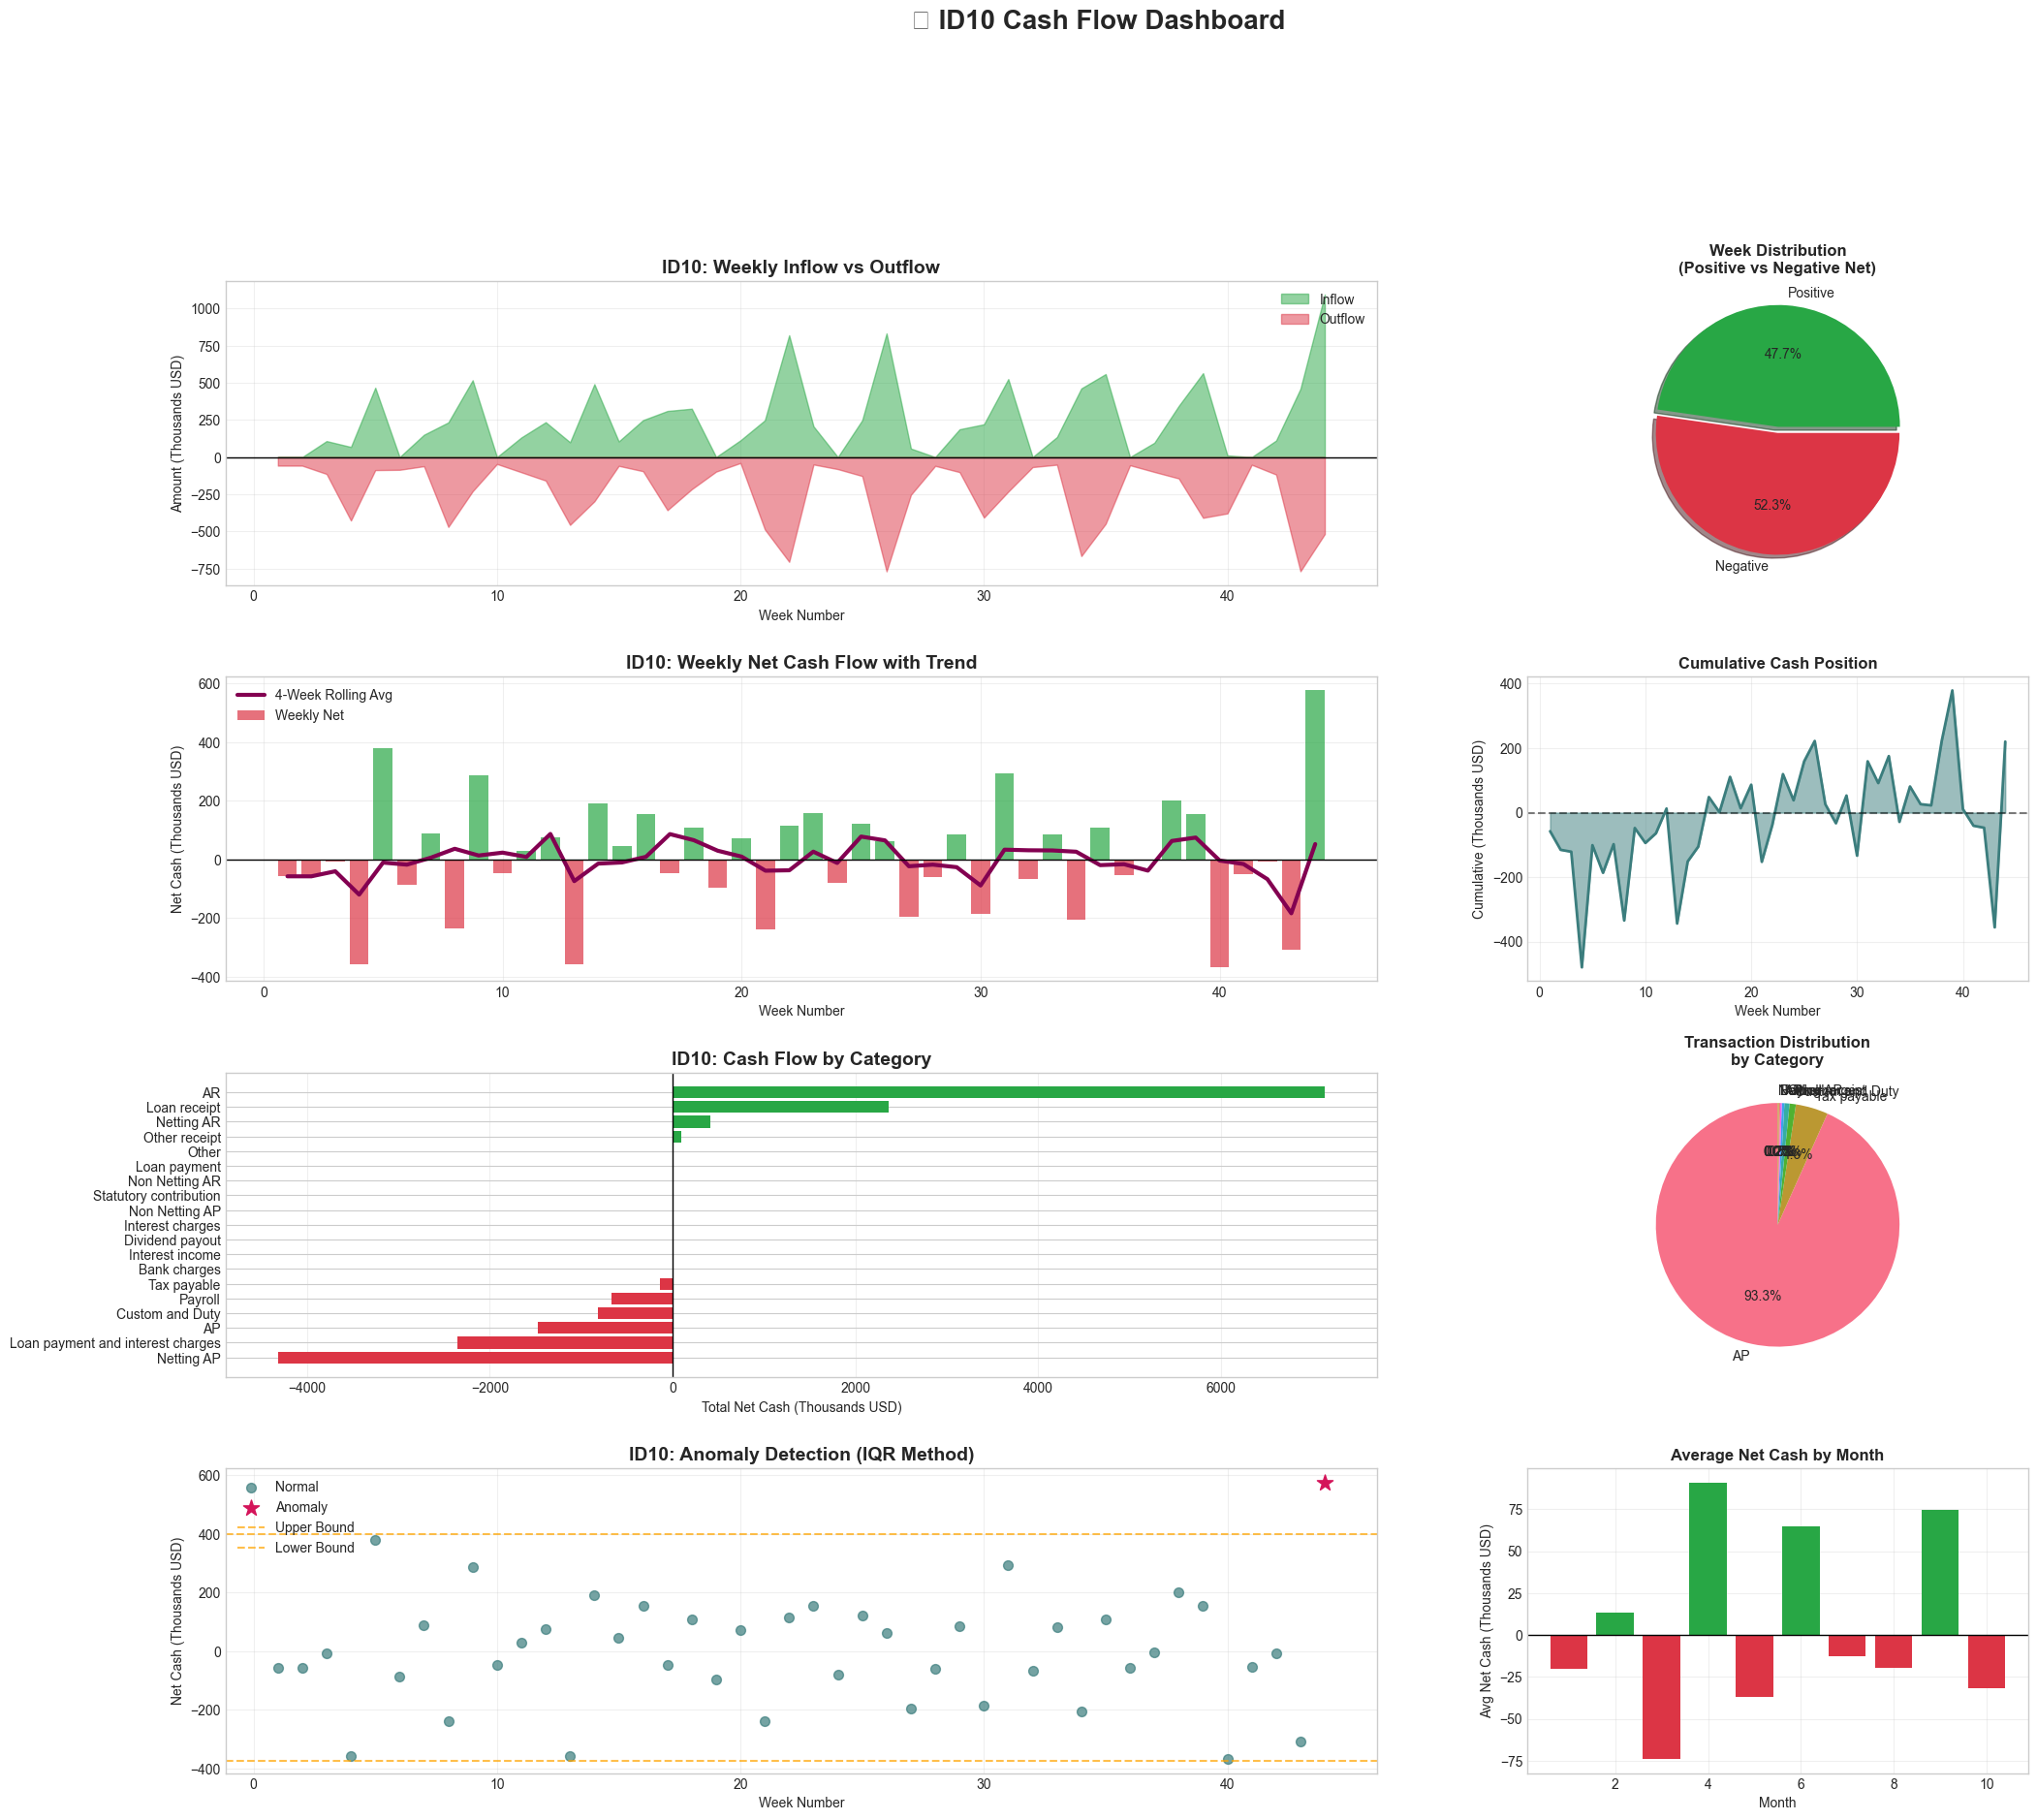


⚠️ Anomalies detected for ID10:


,Week_Num,Week_Start,Total_Net,Total_Inflow,Outflow_Abs
43,44,2025-10-29,576340.69672,1094112.45,517771.75328



🏢 ENTITY: KR10


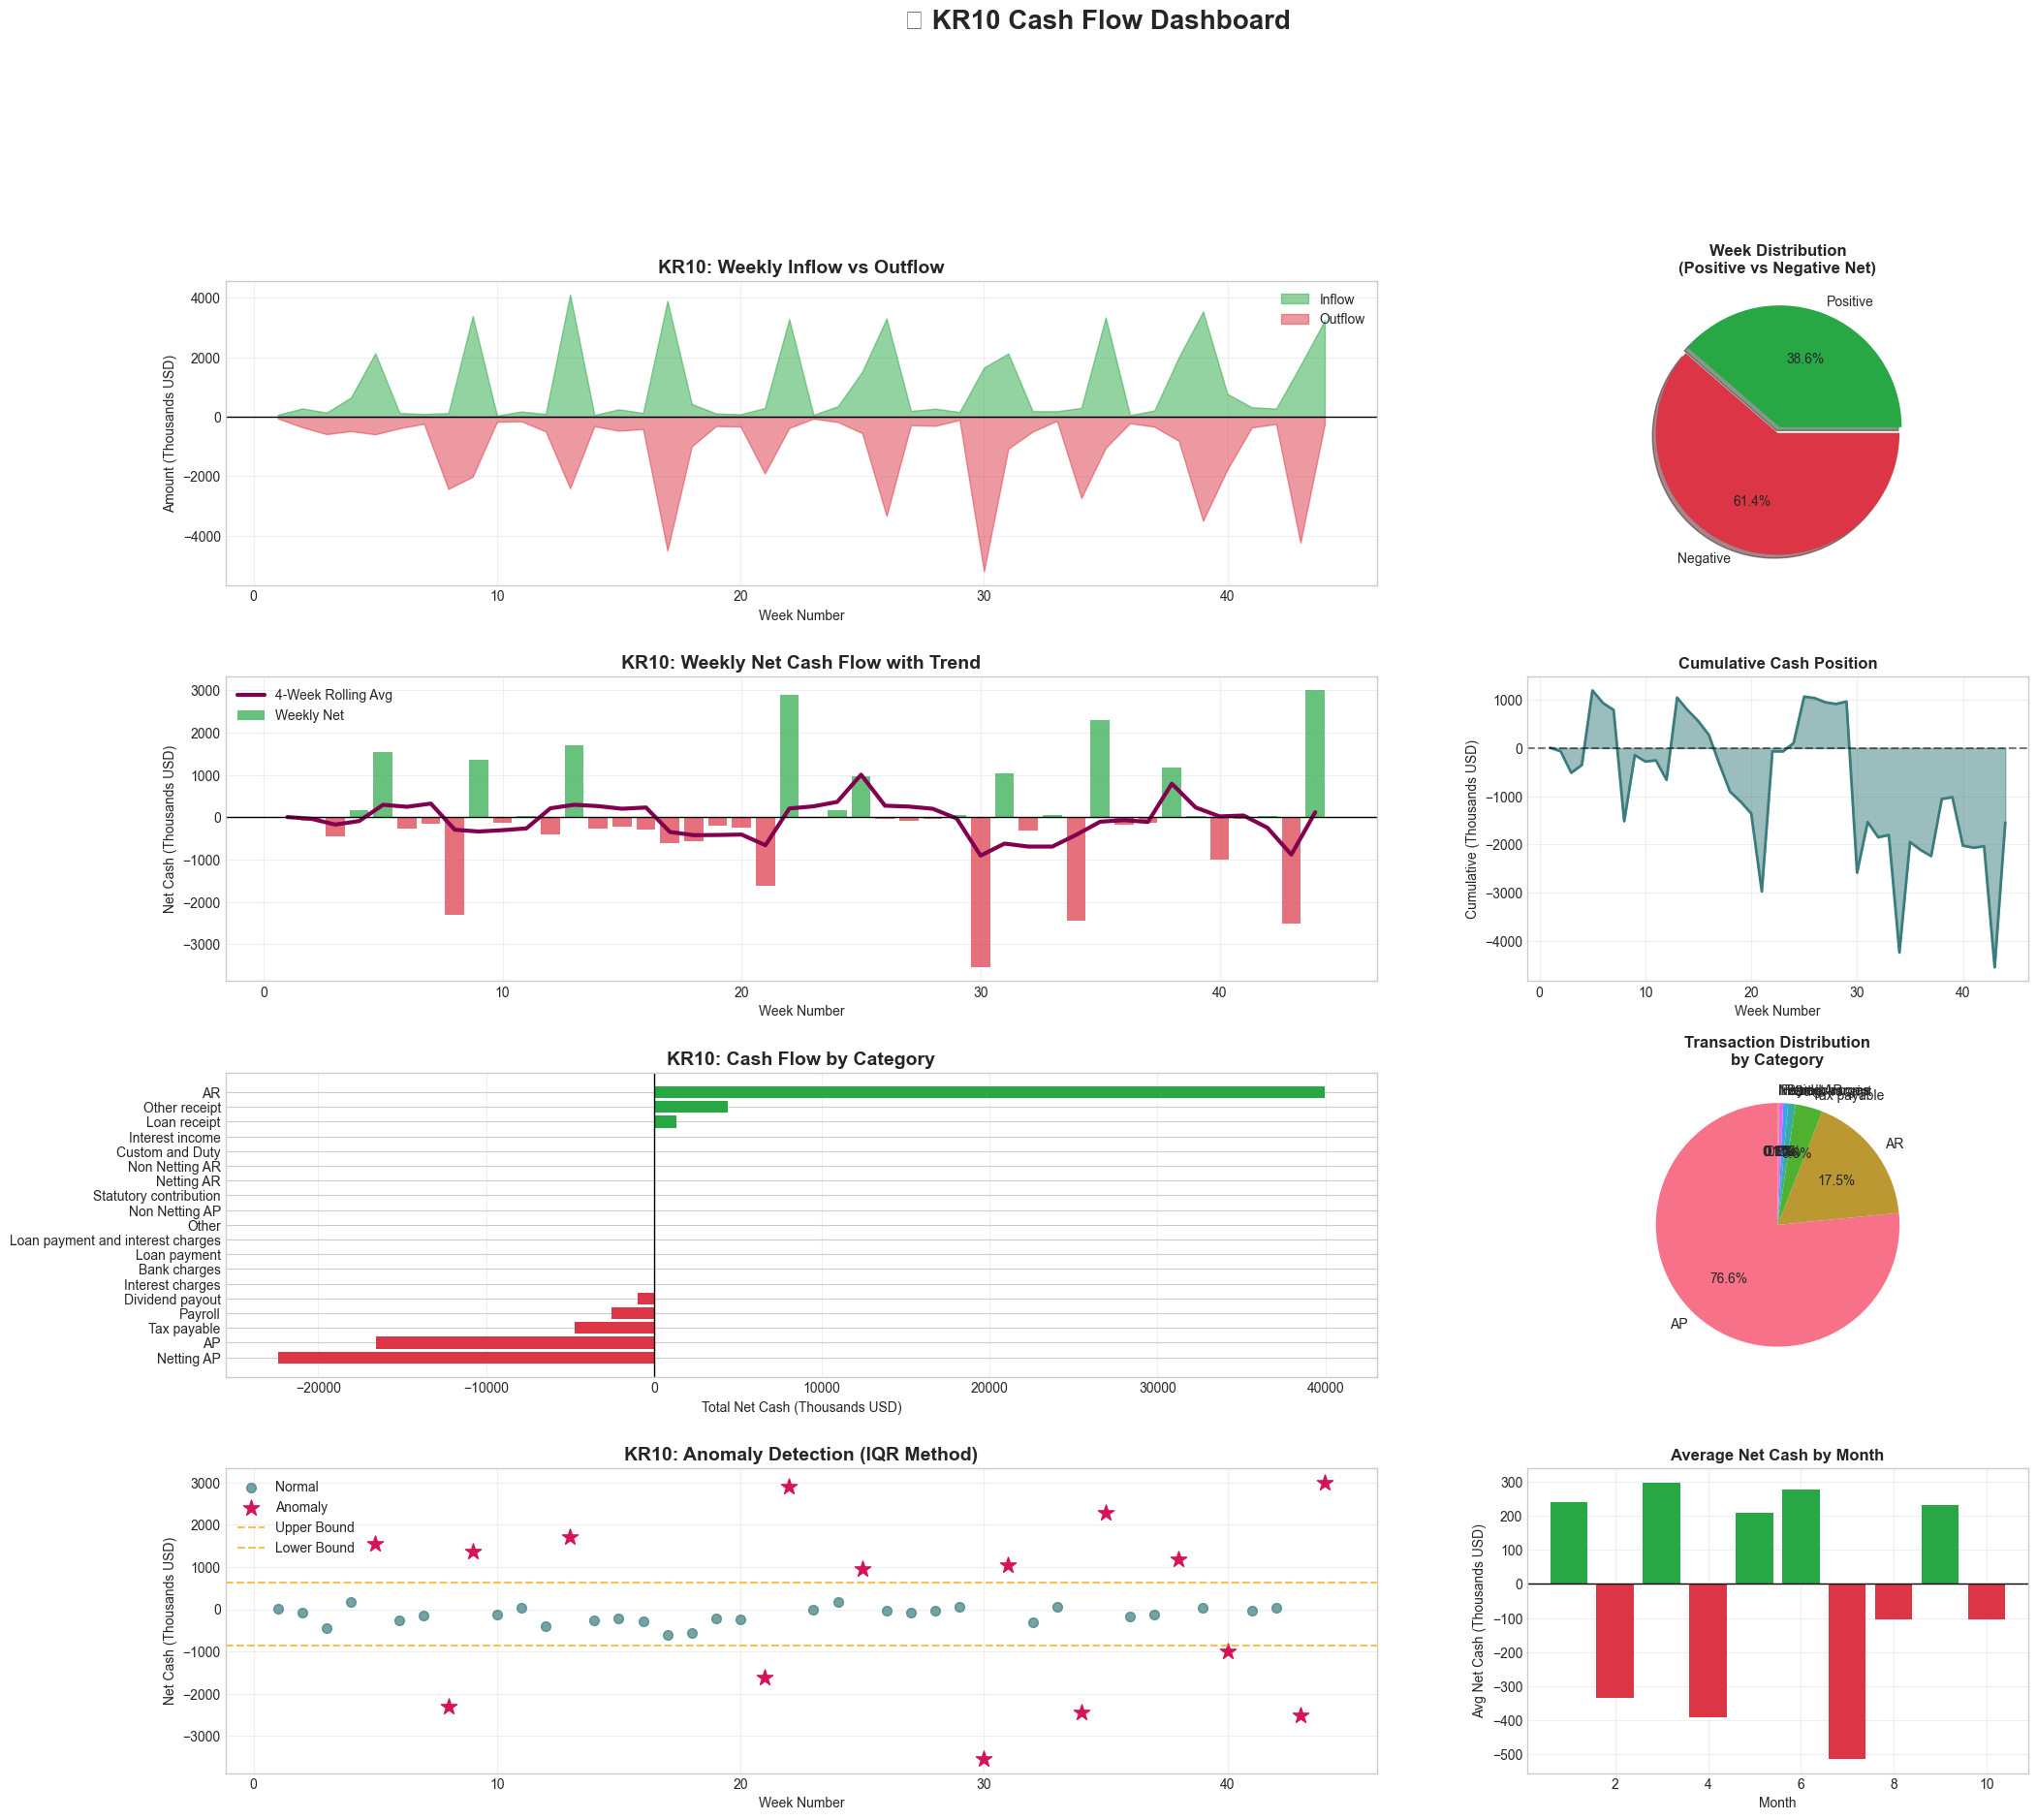


⚠️ Anomalies detected for KR10:


,Week_Num,Week_Start,Total_Net,Total_Inflow,Outflow_Abs
4,5,2025-01-29,1.543694e+06,2.135589e+06,5.918944e+05
7,8,2025-02-19,-2.305389e+06,1.228884e+05,2.428277e+06
8,9,2025-02-26,1.369569e+06,3.388653e+06,2.019084e+06
12,13,2025-03-26,1.704359e+06,4.108957e+06,2.404597e+06
20,21,2025-05-21,-1.616040e+06,2.933834e+05,1.909424e+06
21,22,2025-05-28,2.904710e+06,3.283463e+06,3.787527e+05
24,25,2025-06-18,9.627649e+05,1.516275e+06,5.535103e+05
29,30,2025-07-23,-3.546582e+06,1.653129e+06,5.199711e+06
30,31,2025-07-30,1.050232e+06,2.126601e+06,1.076369e+06
33,34,2025-08-20,-2.436664e+06,2.980249e+05,2.734689e+06



🏢 ENTITY: MY10


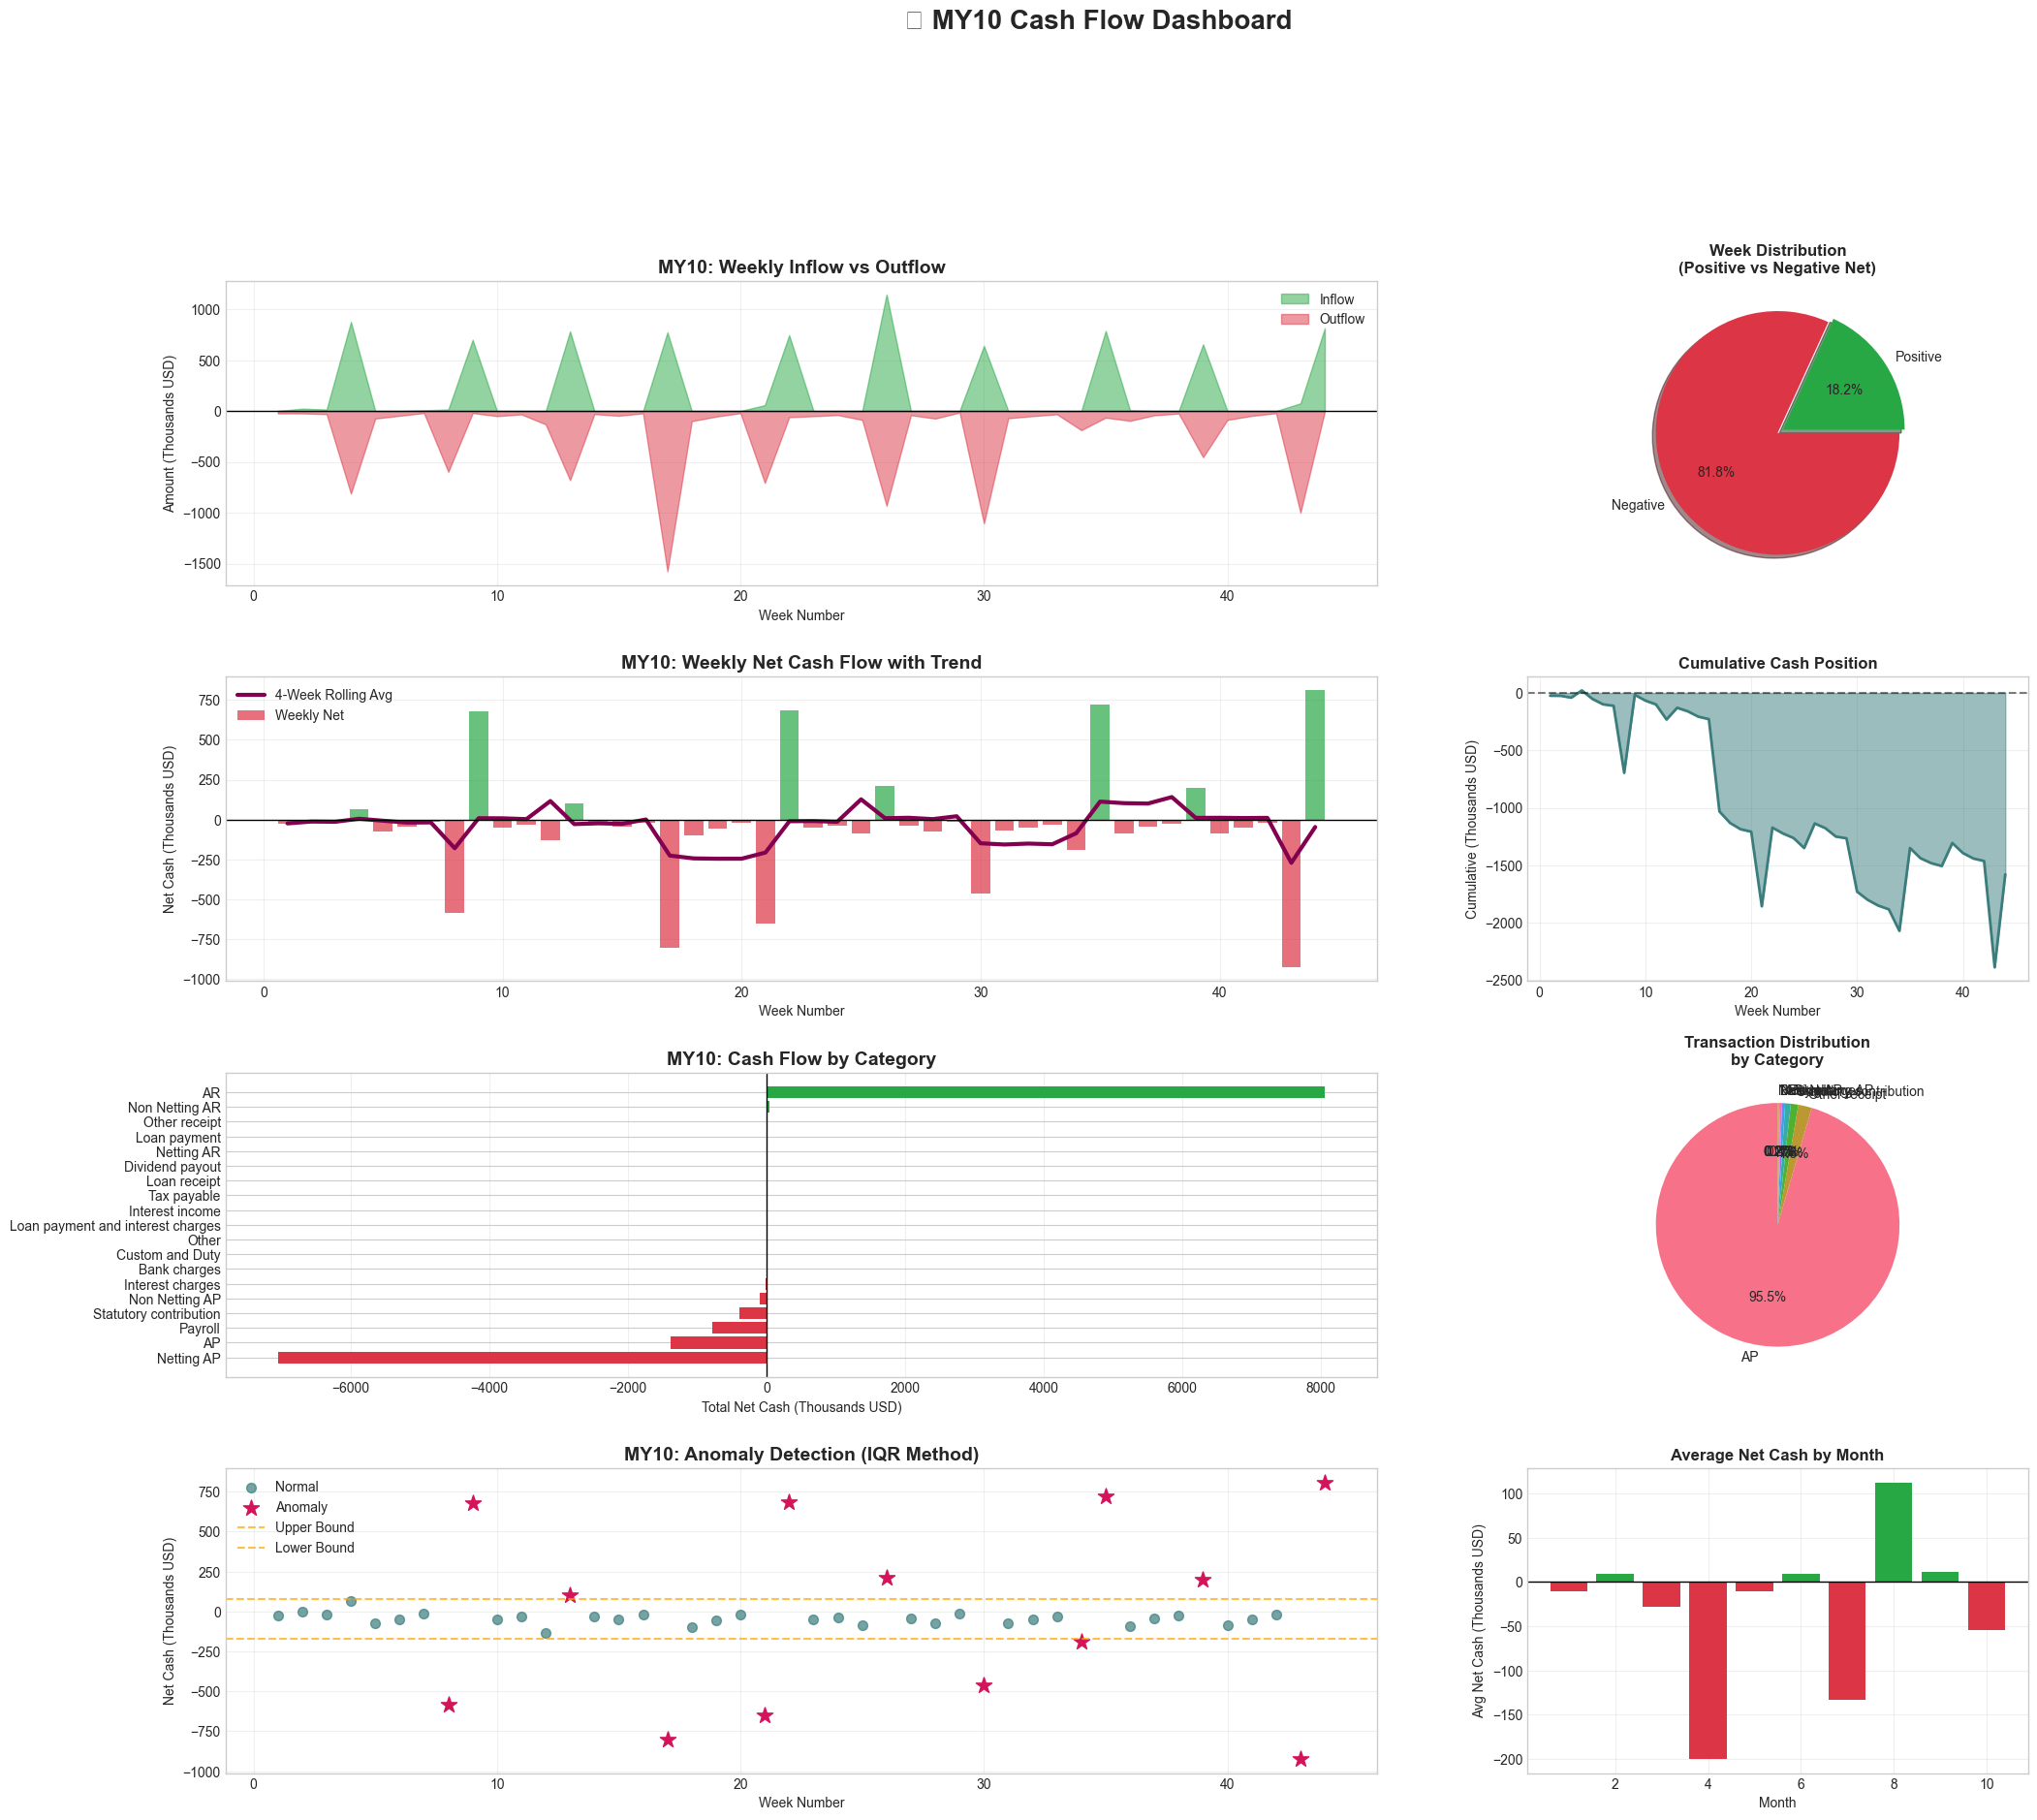


⚠️ Anomalies detected for MY10:


,Week_Num,Week_Start,Total_Net,Total_Inflow,Outflow_Abs
7,8,2025-02-19,-583521.38915,1.468399e+04,5.982054e+05
8,9,2025-02-26,679250.05645,6.994432e+05,2.019315e+04
12,13,2025-03-26,102144.63385,7.824507e+05,6.803061e+05
16,17,2025-04-23,-803688.33829,7.733250e+05,1.577013e+06
20,21,2025-05-21,-649530.18670,5.738347e+04,7.069137e+05
21,22,2025-05-28,685092.05073,7.454333e+05,6.034127e+04
25,26,2025-06-25,213677.96045,1.145396e+06,9.317185e+05
29,30,2025-07-23,-464321.90573,6.402892e+05,1.104611e+06
33,34,2025-08-20,-187862.11958,4.427946e+02,1.883049e+05
34,35,2025-08-27,721348.65181,7.867379e+05,6.538920e+04



🏢 ENTITY: PH10


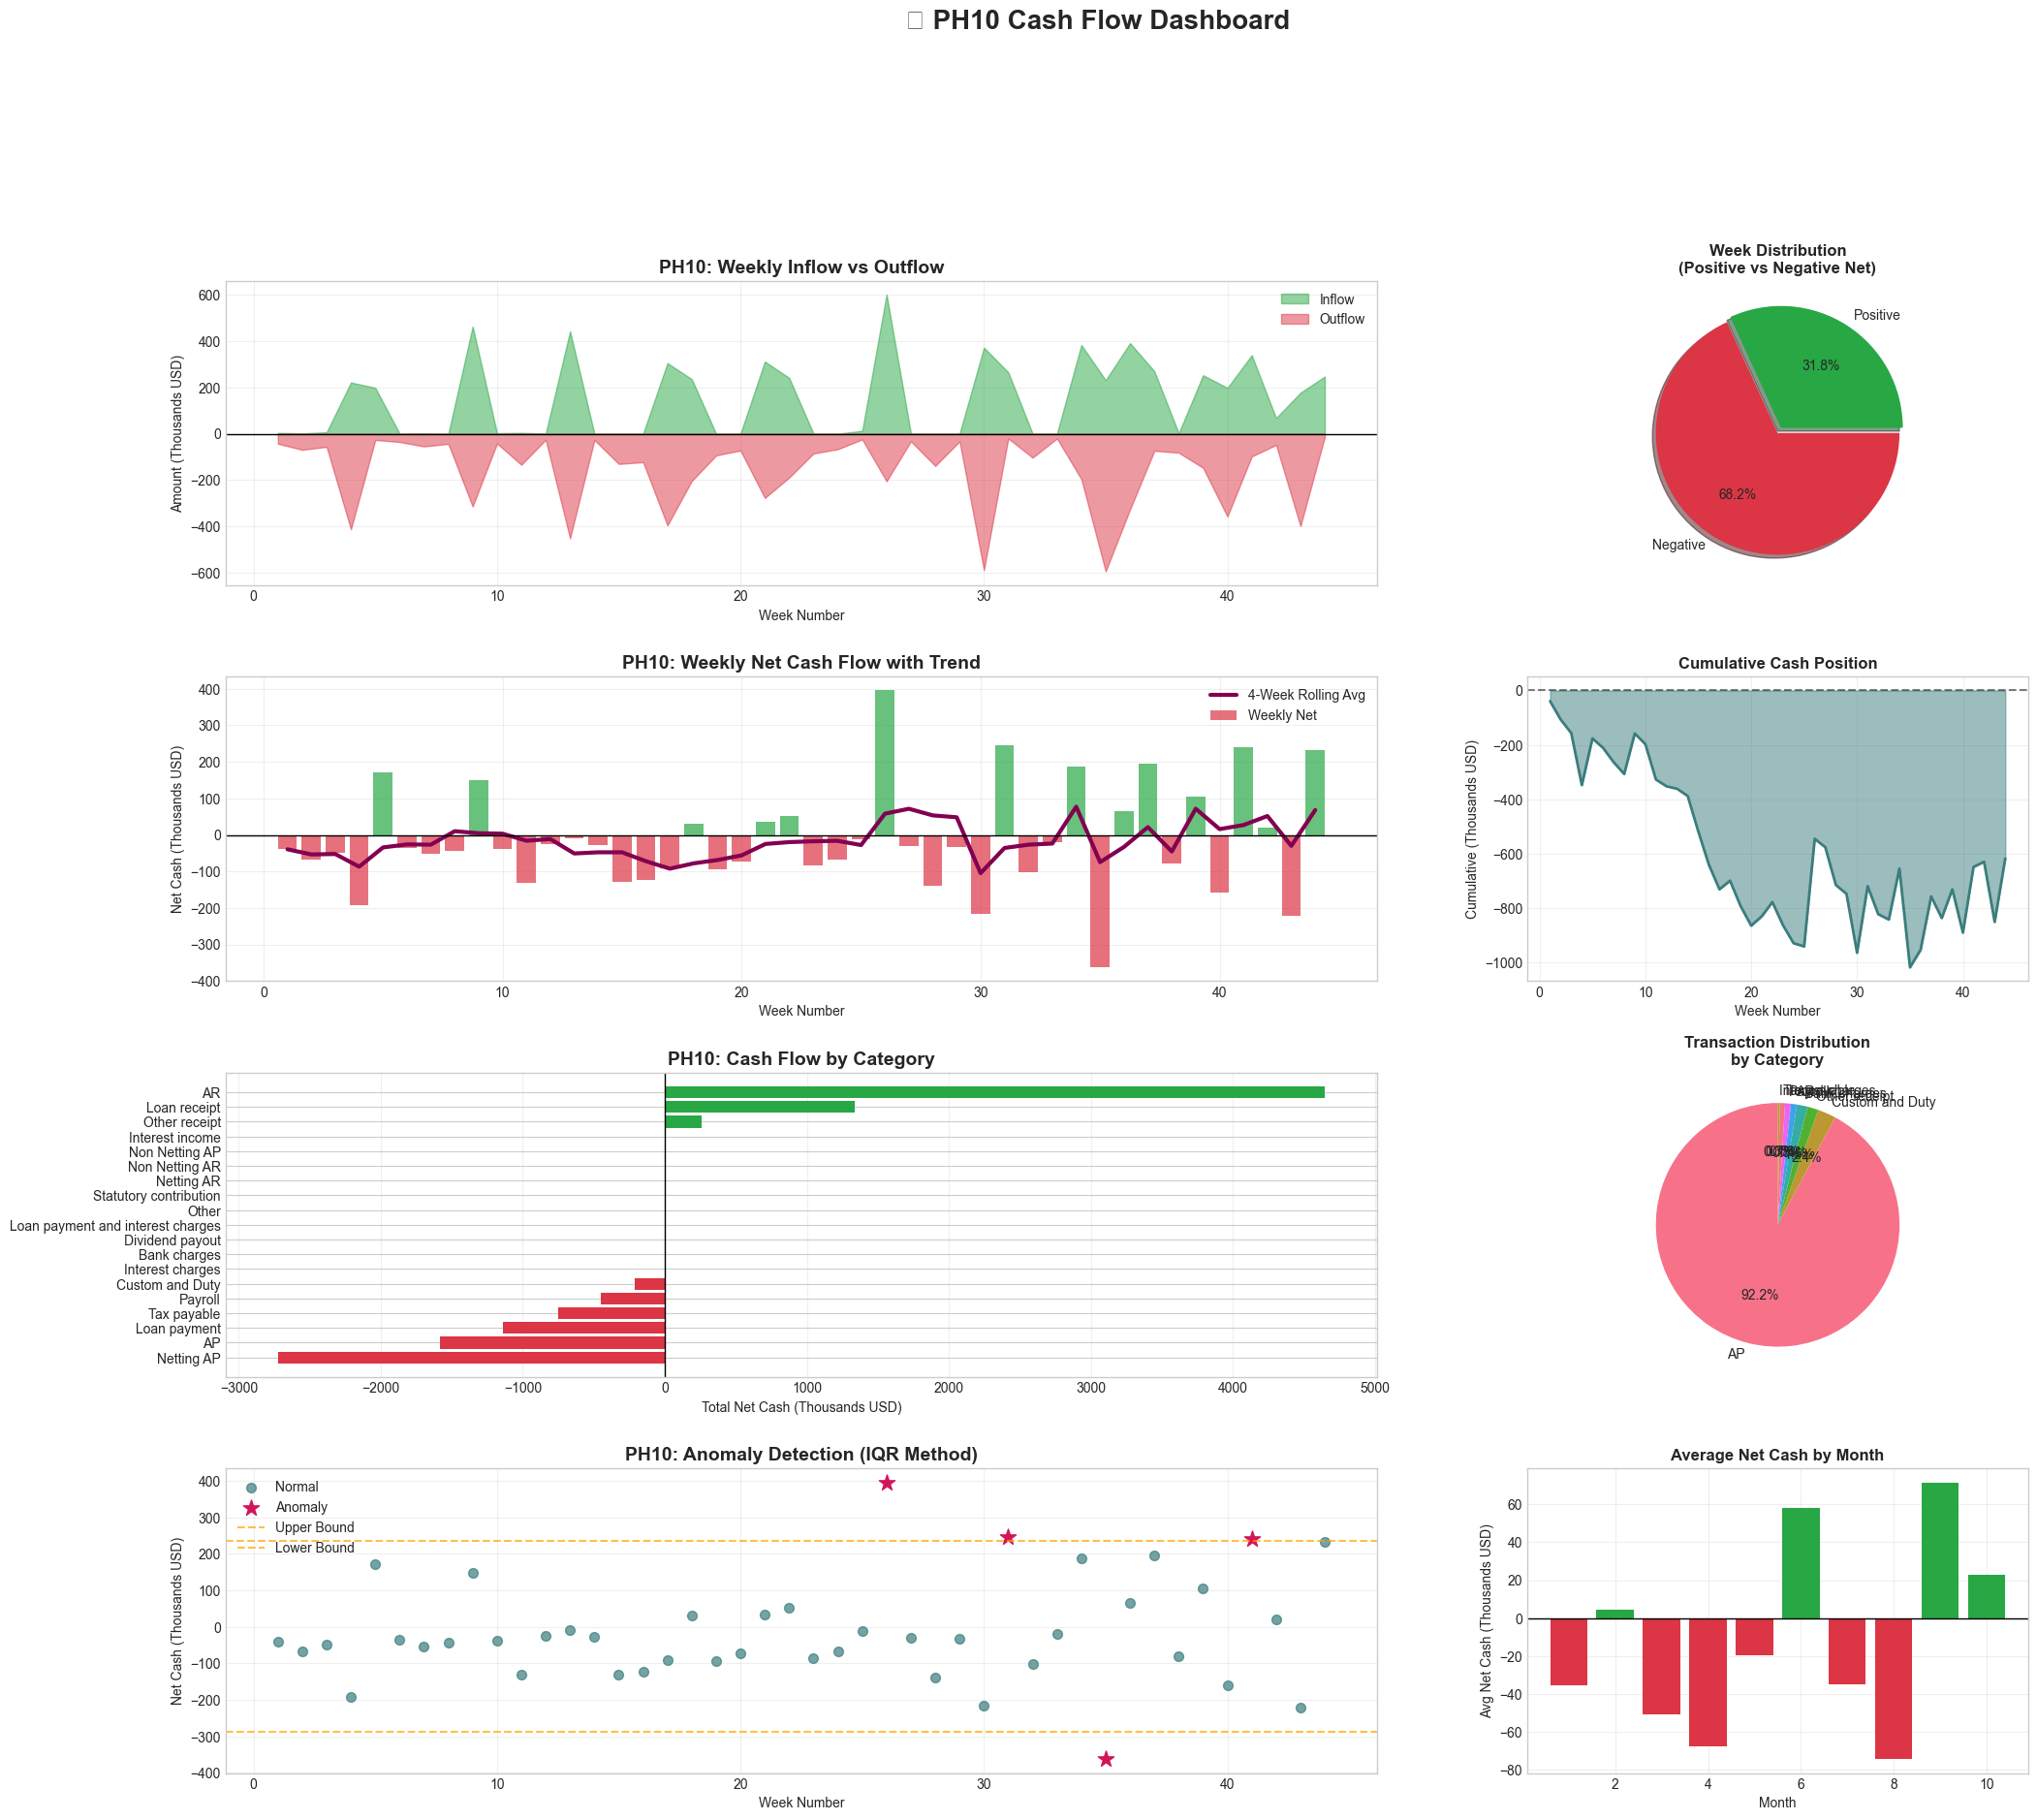


⚠️ Anomalies detected for PH10:


,Week_Num,Week_Start,Total_Net,Total_Inflow,Outflow_Abs
25,26,2025-06-25,395577.64028,600632.82603,205055.18575
30,31,2025-07-30,244666.42334,264923.58974,20257.16640
34,35,2025-08-27,-362567.60156,231067.91504,593635.51660
40,41,2025-10-08,240962.47684,338889.73122,97927.25438



🏢 ENTITY: SS10


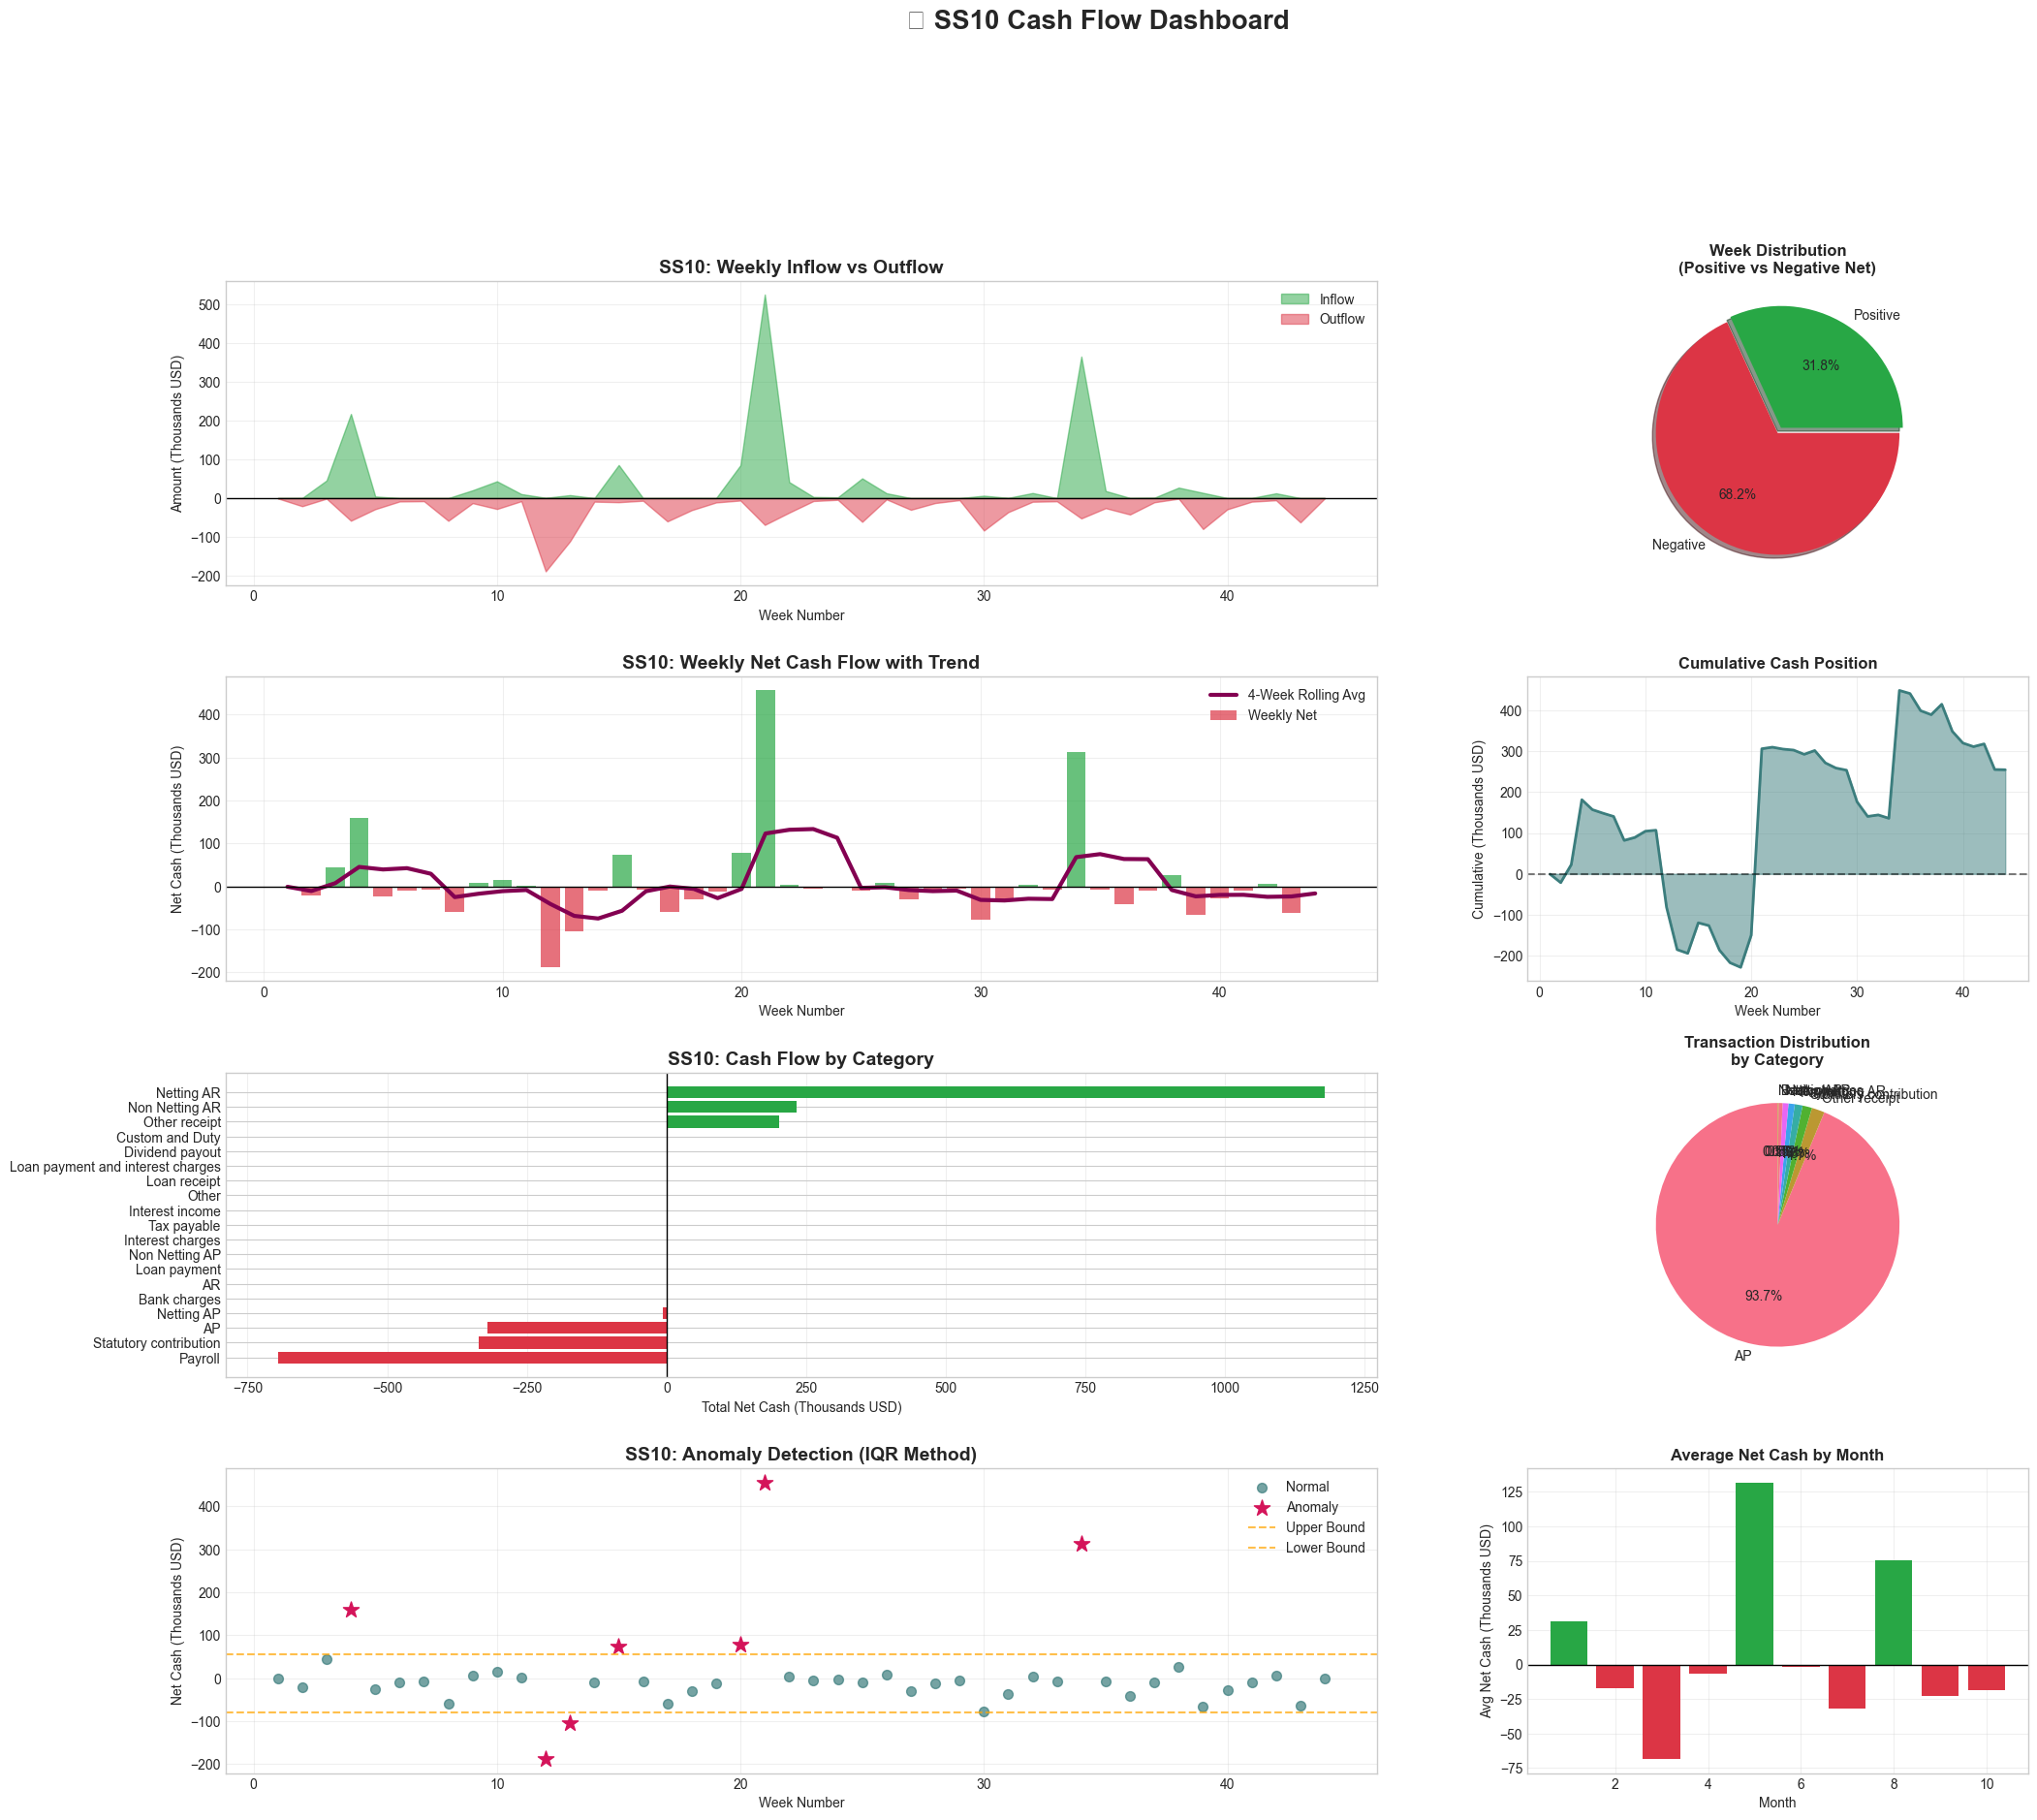


⚠️ Anomalies detected for SS10:


,Week_Num,Week_Start,Total_Net,Total_Inflow,Outflow_Abs
3,4,2025-01-22,158688.40045,217044.82460,58356.42415
11,12,2025-03-19,-188276.64178,764.17648,189040.81826
12,13,2025-03-26,-103699.10172,7690.19912,111389.30084
14,15,2025-04-09,74677.84116,85318.38000,10640.53884
19,20,2025-05-14,78614.60219,84855.23035,6240.62816
20,21,2025-05-21,455987.98965,525145.27886,69157.28921
33,34,2025-08-20,312690.26121,365073.93000,52383.66879



🏢 ENTITY: TH10


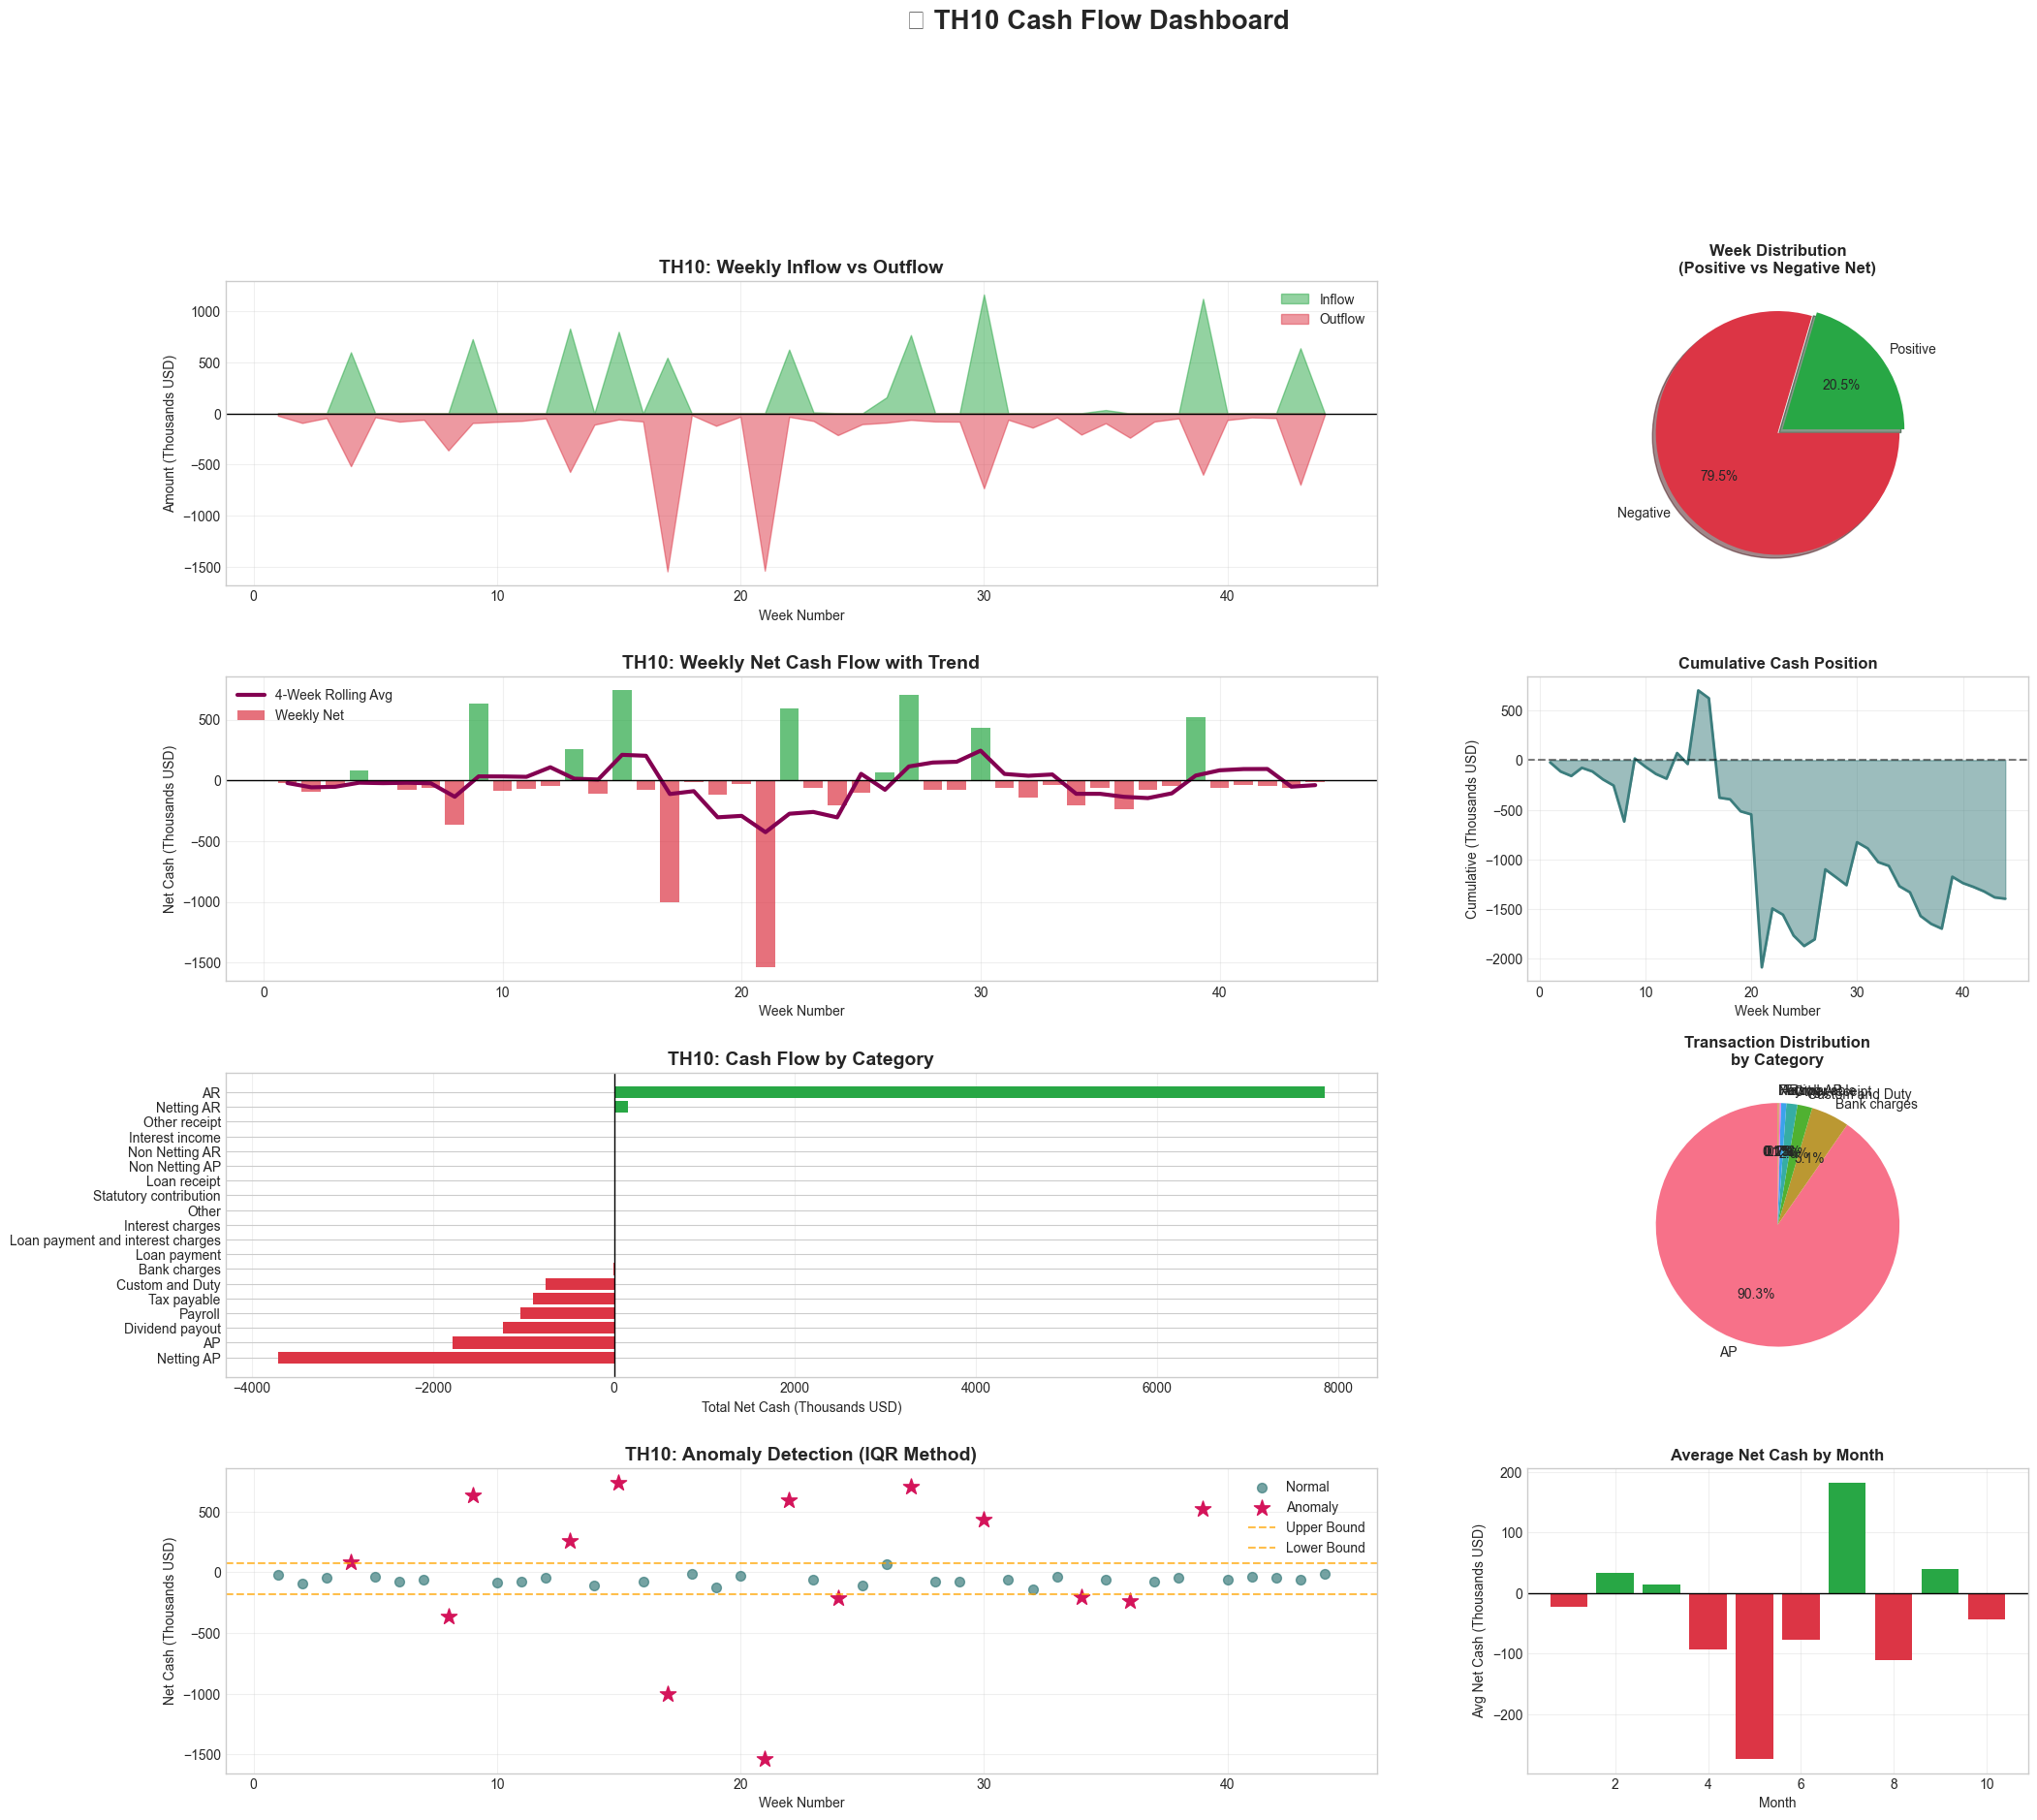


⚠️ Anomalies detected for TH10:


,Week_Num,Week_Start,Total_Net,Total_Inflow,Outflow_Abs
3,4,2025-01-22,8.187026e+04,5.987042e+05,5.168340e+05
7,8,2025-02-19,-3.618138e+05,0.000000e+00,3.618138e+05
8,9,2025-02-26,6.339601e+05,7.275973e+05,9.363714e+04
12,13,2025-03-26,2.577901e+05,8.302058e+05,5.724156e+05
14,15,2025-04-09,7.401658e+05,7.988852e+05,5.871935e+04
16,17,2025-04-23,-1.001072e+06,5.450576e+05,1.546129e+06
20,21,2025-05-21,-1.539050e+06,0.000000e+00,1.539050e+06
21,22,2025-05-28,5.918381e+05,6.249833e+05,3.314517e+04
23,24,2025-06-11,-2.093053e+05,2.862840e+03,2.121681e+05
26,27,2025-07-02,7.037052e+05,7.671008e+05,6.339562e+04



🏢 ENTITY: TW10


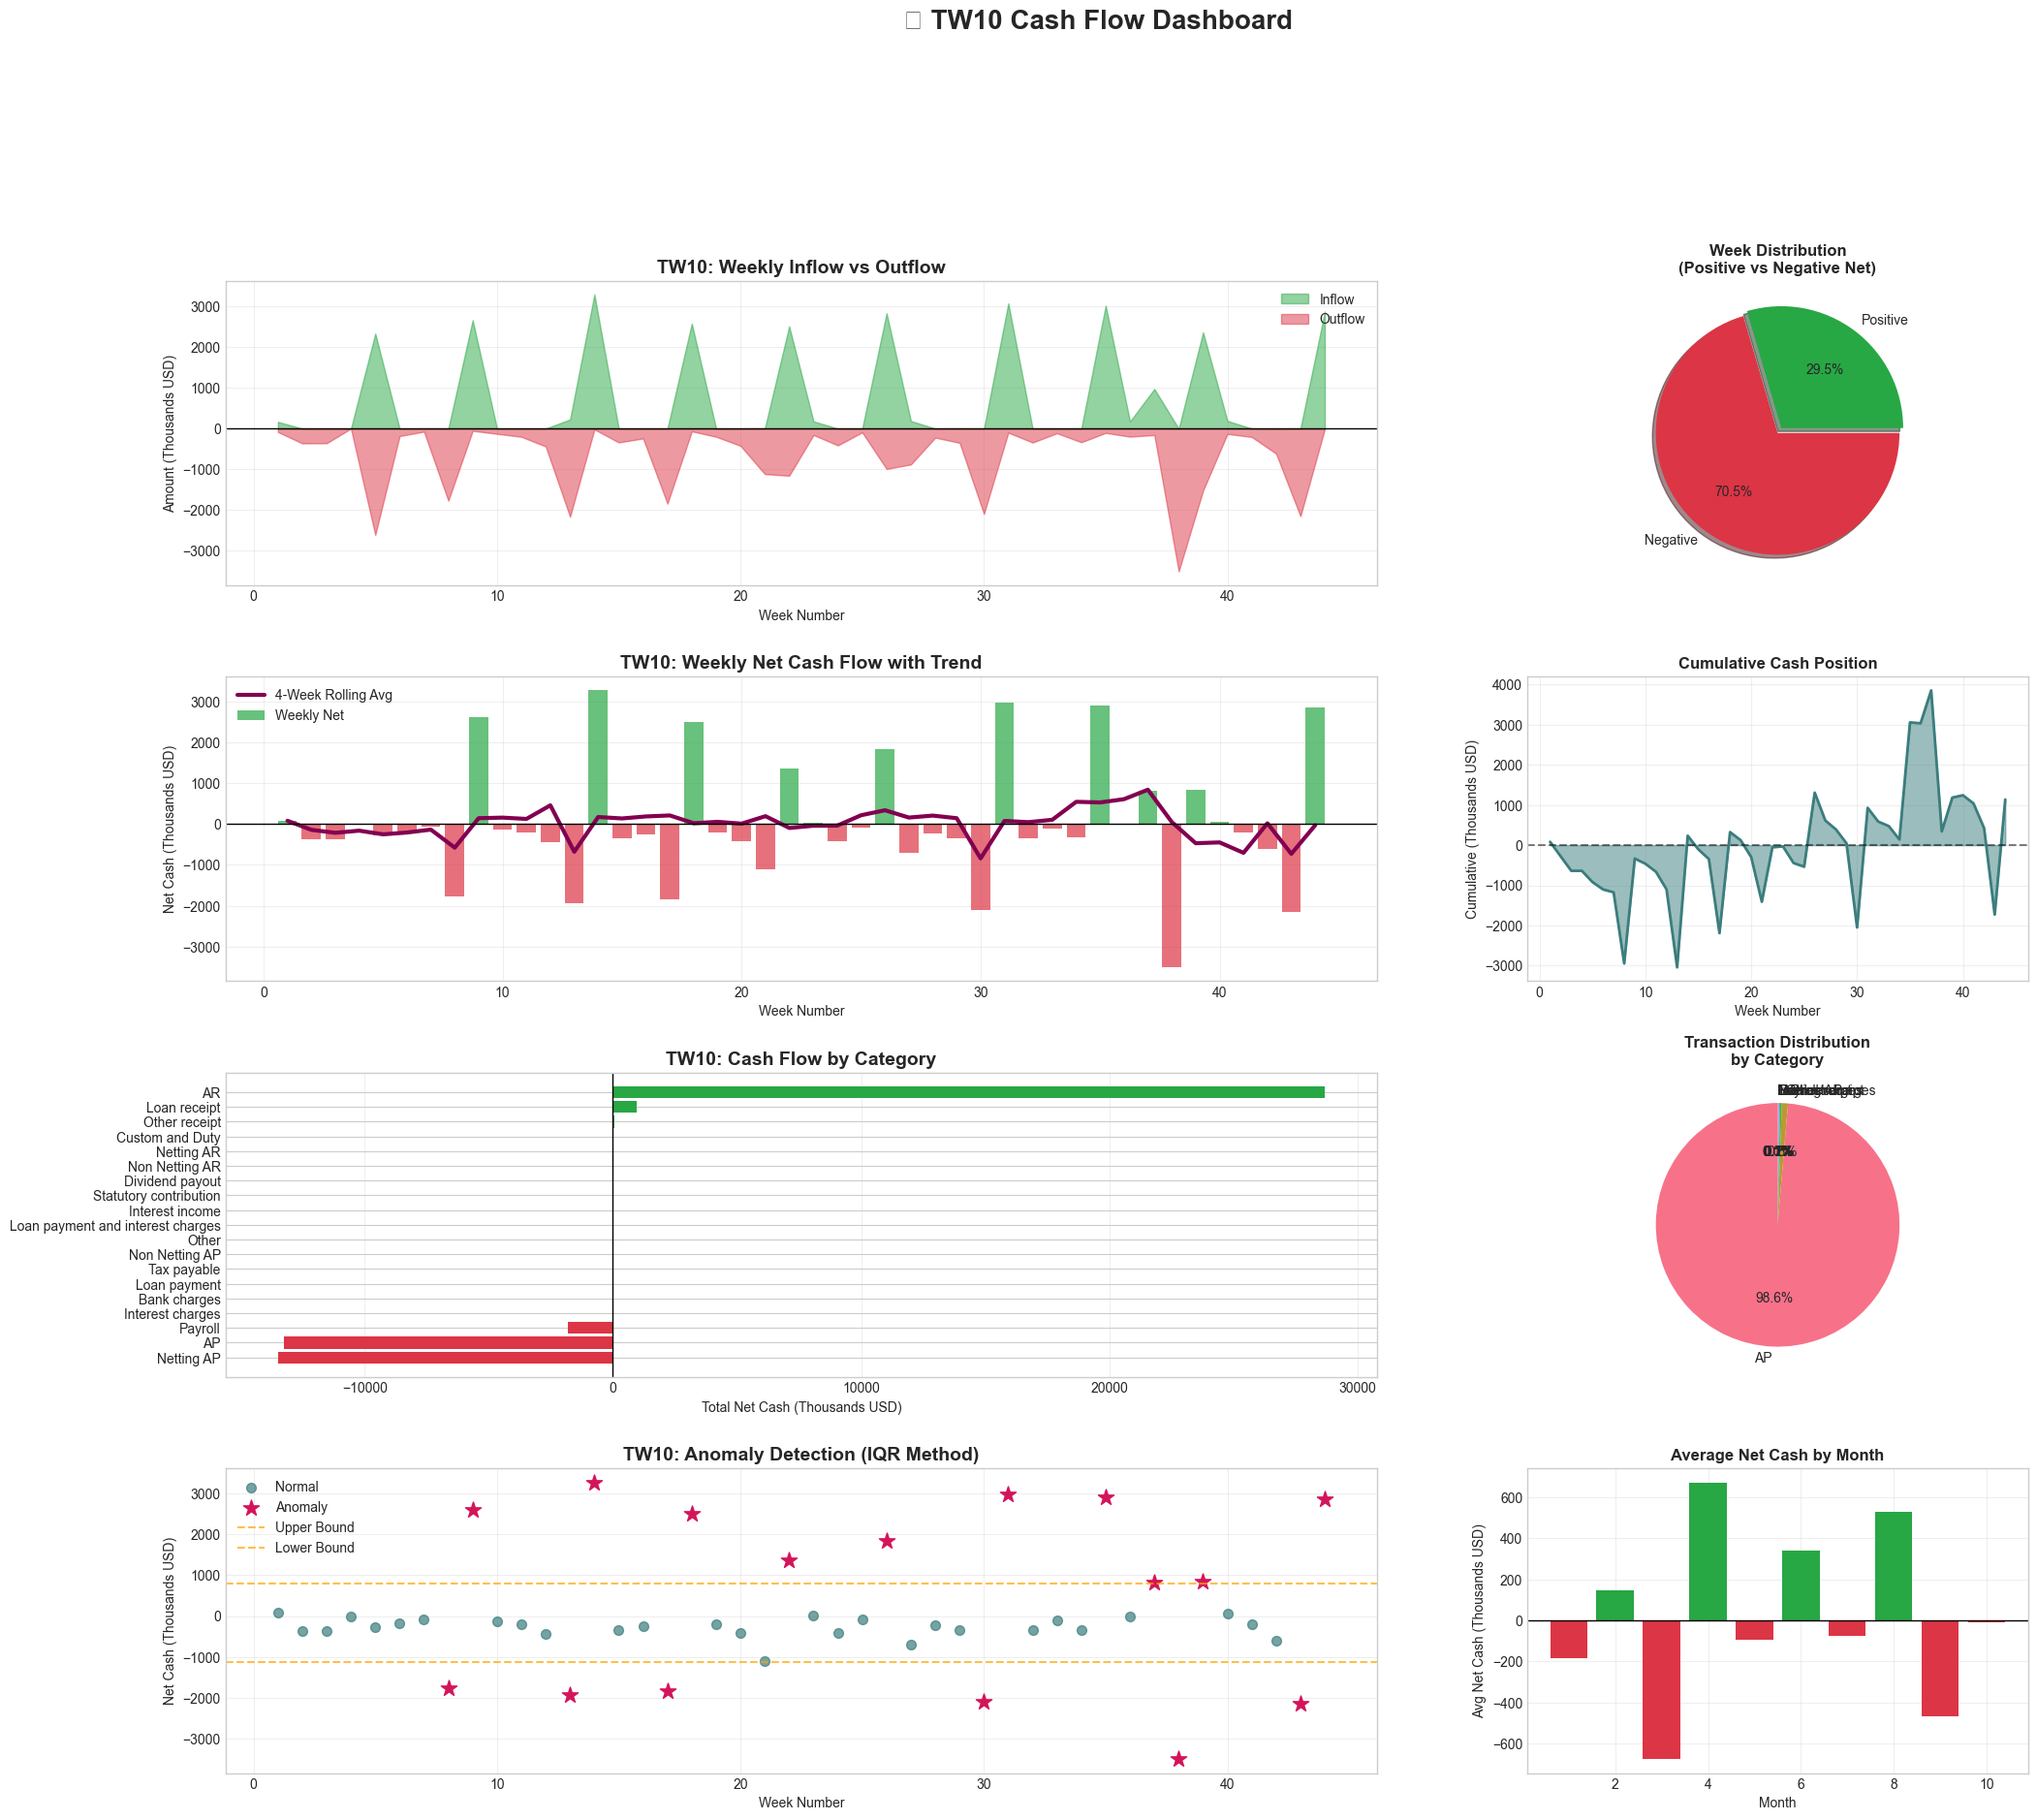


⚠️ Anomalies detected for TW10:


,Week_Num,Week_Start,Total_Net,Total_Inflow,Outflow_Abs
7,8,2025-02-19,-1.771321e+06,1.235584e+03,1.772556e+06
8,9,2025-02-26,2.611714e+06,2.666162e+06,5.444810e+04
12,13,2025-03-26,-1.940381e+06,2.251877e+05,2.165568e+06
13,14,2025-04-02,3.276857e+06,3.296157e+06,1.929970e+04
16,17,2025-04-23,-1.843779e+06,5.140991e+02,1.844293e+06
17,18,2025-04-30,2.514589e+06,2.581728e+06,6.713829e+04
21,22,2025-05-28,1.355443e+06,2.513844e+06,1.158401e+06
25,26,2025-06-25,1.844318e+06,2.835649e+06,9.913307e+05
29,30,2025-07-23,-2.095323e+06,1.213032e+03,2.096536e+06
30,31,2025-07-30,2.978214e+06,3.077679e+06,9.946488e+04



🏢 ENTITY: VN20


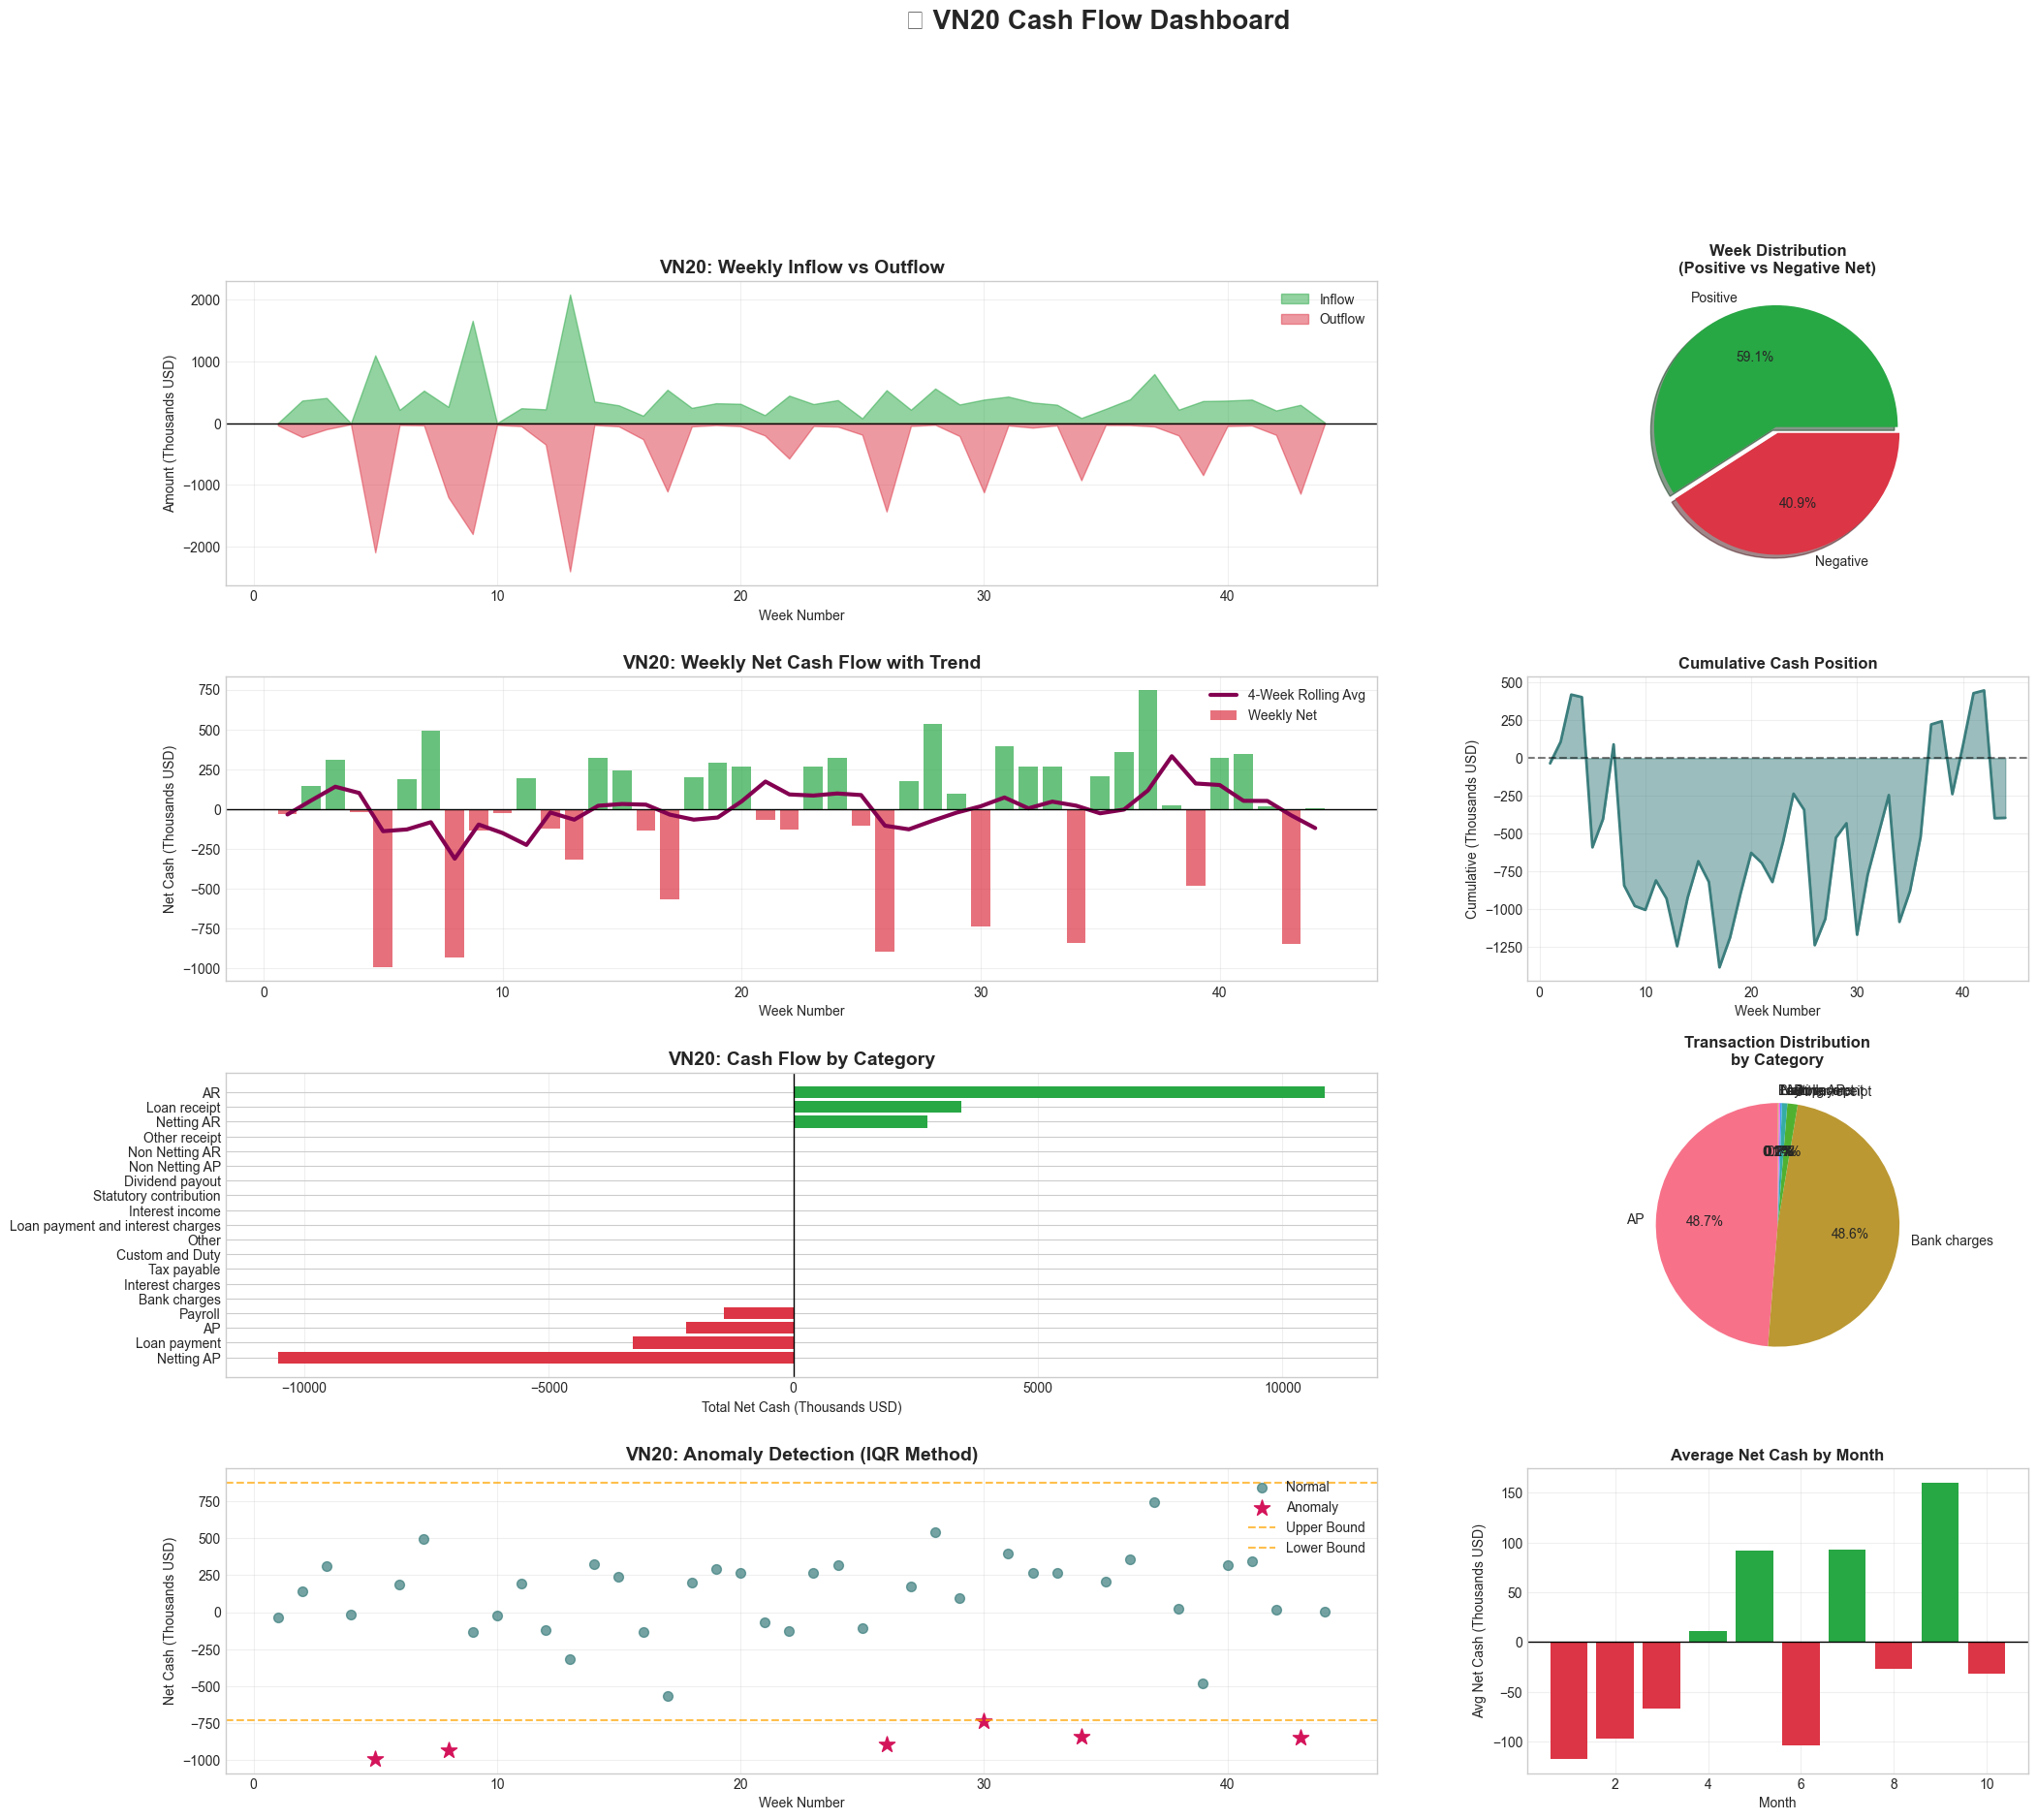


⚠️ Anomalies detected for VN20:


,Week_Num,Week_Start,Total_Net,Total_Inflow,Outflow_Abs
4,5,2025-01-29,-993605.40133,1.100268e+06,2.093874e+06
7,8,2025-02-19,-934187.24195,2.652491e+05,1.199436e+06
25,26,2025-06-25,-895661.56794,5.356668e+05,1.431328e+06
29,30,2025-07-23,-737626.52589,3.829368e+05,1.120563e+06
33,34,2025-08-20,-839198.48096,8.492589e+04,9.241244e+05
42,43,2025-10-22,-845517.93220,2.979045e+05,1.143422e+06


In [6]:
# Create output directory
import os
os.makedirs('../outputs', exist_ok=True)

# Generate dashboard for each entity
for entity in entities:
    print(f"\n{'='*60}")
    print(f"🏢 ENTITY: {entity}")
    print('='*60)
    entity_data[entity] = create_entity_dashboard(entity, entity_data[entity])

---
## 3. Cross-Entity Pattern Analysis

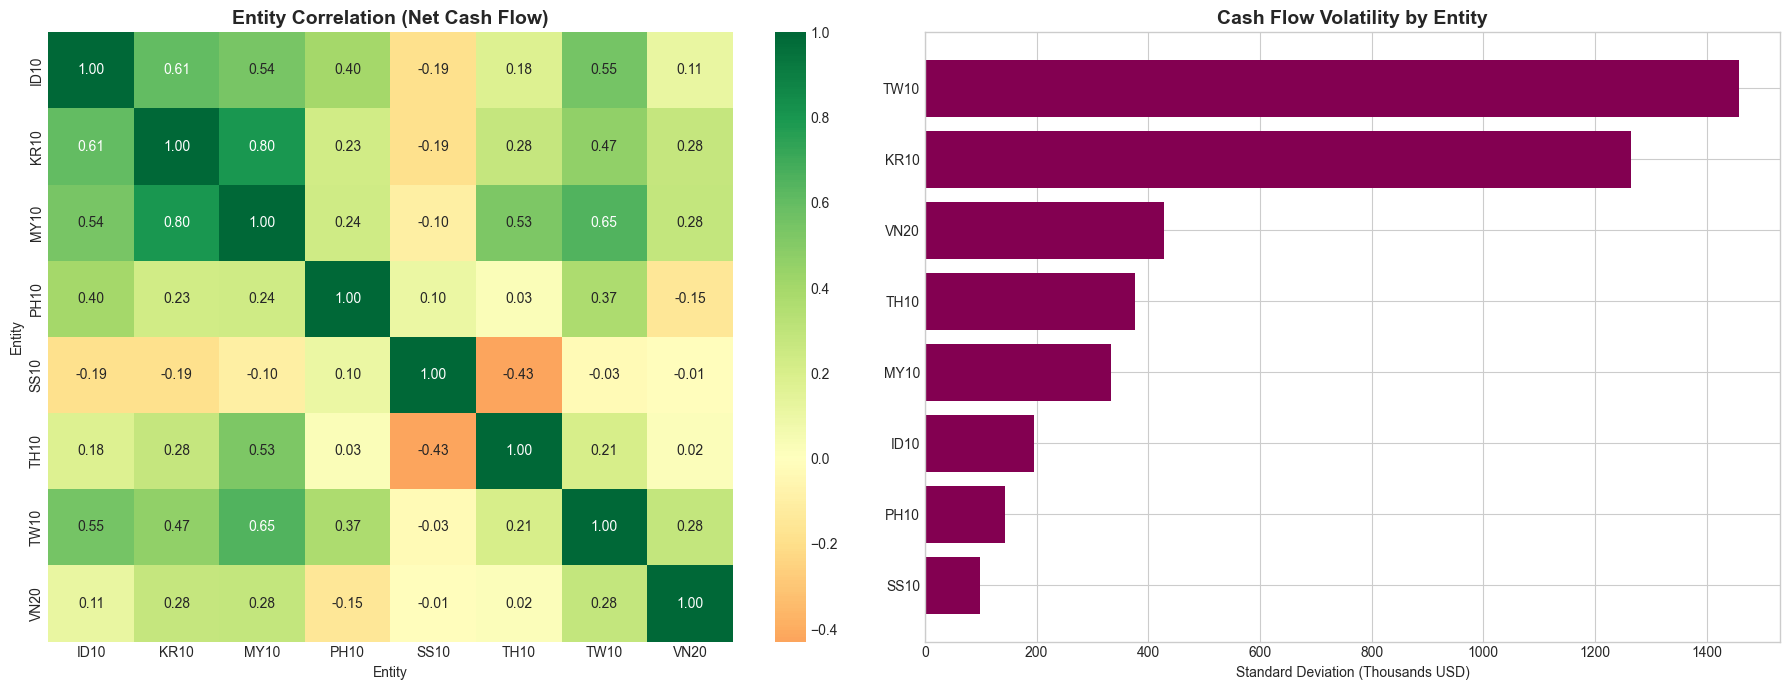

In [7]:
# Correlation between entities
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Pivot for correlation
pivot_corr = df_all.pivot(index='Week_Num', columns='Entity', values='Total_Net')

# 1. Correlation Heatmap
ax1 = axes[0]
corr = pivot_corr.corr()
sns.heatmap(corr, annot=True, cmap='RdYlGn', center=0, ax=ax1, fmt='.2f')
ax1.set_title('Entity Correlation (Net Cash Flow)', fontsize=14, fontweight='bold')

# 2. Volatility Comparison
ax2 = axes[1]
volatility = df_all.groupby('Entity')['Total_Net'].std().sort_values()
ax2.barh(volatility.index, volatility.values/1e3, color=AZ_COLORS['primary'])
ax2.set_xlabel('Standard Deviation (Thousands USD)')
ax2.set_title('Cash Flow Volatility by Entity', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/cross_entity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

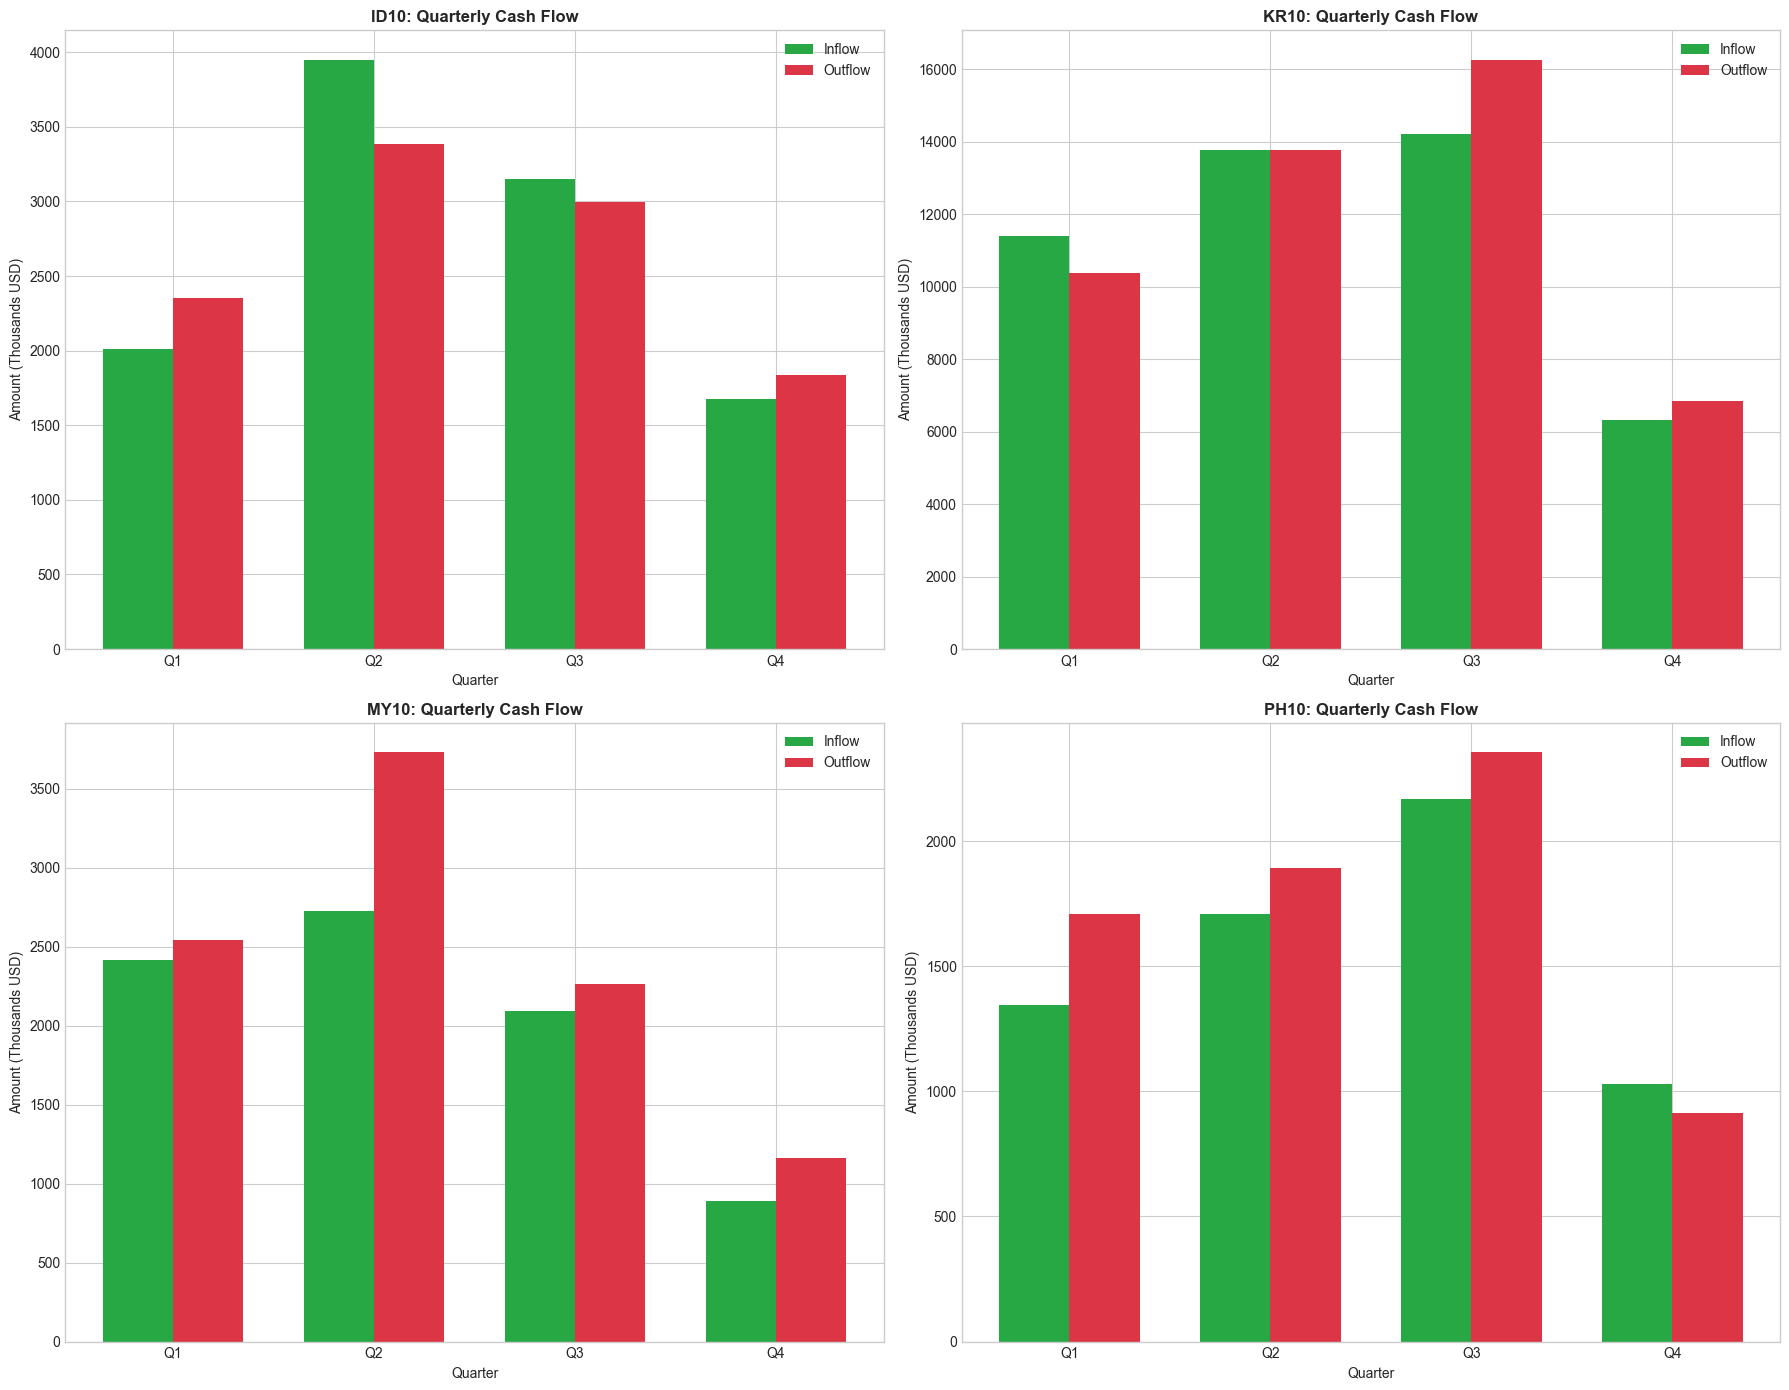

In [8]:
# Quarterly Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

quarterly = df_all.groupby(['Entity', 'Quarter']).agg({
    'Total_Net': 'sum',
    'Total_Inflow': 'sum',
    'Outflow_Abs': 'sum'
}).reset_index()

for idx, entity in enumerate(entities[:4]):
    ax = axes[idx // 2, idx % 2]
    entity_q = quarterly[quarterly['Entity'] == entity]
    x = np.arange(len(entity_q))
    width = 0.35
    ax.bar(x - width/2, entity_q['Total_Inflow']/1e3, width, label='Inflow', color=AZ_COLORS['positive'])
    ax.bar(x + width/2, entity_q['Outflow_Abs']/1e3, width, label='Outflow', color=AZ_COLORS['negative'])
    ax.set_xlabel('Quarter')
    ax.set_ylabel('Amount (Thousands USD)')
    ax.set_title(f'{entity}: Quarterly Cash Flow', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Q{int(q)}' for q in entity_q['Quarter']])
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/quarterly_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Summary Report

In [9]:
# Generate summary for each entity
print("\n" + "="*80)
print("📈 CASH FLOW ANALYSIS SUMMARY")
print("="*80)

for entity in entities:
    df = entity_data[entity]
    total_net = df['Total_Net'].sum()
    total_inflow = df['Total_Inflow'].sum()
    total_outflow = df['Outflow_Abs'].sum()
    num_anomalies = df['is_anomaly'].sum() if 'is_anomaly' in df.columns else 0
    
    print(f"\n🏢 {entity}:")
    print(f"   Total Net: ${total_net:,.2f}")
    print(f"   Total Inflow: ${total_inflow:,.2f}")
    print(f"   Total Outflow: ${total_outflow:,.2f}")
    print(f"   Cash Flow Ratio: {(total_inflow/total_outflow)*100:.1f}%")
    print(f"   Anomalous Weeks: {num_anomalies}")


📈 CASH FLOW ANALYSIS SUMMARY

🏢 ID10:
   Total Net: $220,366.43
   Total Inflow: $10,785,260.74
   Total Outflow: $10,564,894.31
   Cash Flow Ratio: 102.1%
   Anomalous Weeks: 1

🏢 KR10:
   Total Net: $-1,543,028.65
   Total Inflow: $45,709,866.98
   Total Outflow: $47,252,895.62
   Cash Flow Ratio: 96.7%
   Anomalous Weeks: 15

🏢 MY10:
   Total Net: $-1,579,799.21
   Total Inflow: $8,121,195.00
   Total Outflow: $9,700,994.21
   Cash Flow Ratio: 83.7%
   Anomalous Weeks: 13

🏢 PH10:
   Total Net: $-617,601.02
   Total Inflow: $6,252,693.11
   Total Outflow: $6,870,294.12
   Cash Flow Ratio: 91.0%
   Anomalous Weeks: 4

🏢 SS10:
   Total Net: $254,603.77
   Total Inflow: $1,613,165.09
   Total Outflow: $1,358,561.31
   Cash Flow Ratio: 118.7%
   Anomalous Weeks: 7

🏢 TH10:
   Total Net: $-1,394,474.38
   Total Inflow: $8,026,941.75
   Total Outflow: $9,421,416.14
   Cash Flow Ratio: 85.2%
   Anomalous Weeks: 14

🏢 TW10:
   Total Net: $1,137,274.69
   Total Inflow: $29,695,688.04
   Tot